#### IMPORT

In [1]:
import matplotlib.pyplot as plt
import os
import re
from glob import glob
import numpy as np
import cv2
import dlib
import datetime as dt
import pandas as pd
import mediapipe as mp

In [2]:
import os
import re
from glob import glob
import numpy as np
import cv2
import dlib
import datetime as dt
import pandas as pd
# import mediapipe as mp

#### Load File

In [2]:
subject_name = '01-01/'
dataset_path = 'PURE/'

img_frame_path = dataset_path + subject_name + subject_name

png_list = glob(img_frame_path + '*.png')
png_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
# print(f"First 10 frames: {png_list[:10]}")S
print(f"Length: {len(png_list)}")

Length: 2108


#### Global Variabel

In [3]:
idx_frame_start = 0
idx_frame_end = len(png_list) - 1
fps = 30
n_segment = 2
left_expand_ratio = 0.25
top_expand_ratio = 0.25

f_cnt = 0
i_cnt = idx_frame_start

In [4]:
detector = dlib.get_frontal_face_detector() # Face detection

In [5]:
face_left, face_top, face_right, face_bottom = 0,0,0,0
mask = None
n_skinpixels = 0

#### Landmarking

In [6]:
# Initialize MediaPipe Face Mesh (set static_image_mode to False for video processing)
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

f_cnt = 0
i_cnt = idx_frame_start

# Load images (assuming png_list is already defined)
while i_cnt >= idx_frame_start and i_cnt <= idx_frame_end:

    # Read the image and resize for performance improvement
    frame = cv2.imread(png_list[i_cnt])
    scale_percent = 60  # Resize image by 60% for faster processing
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    resized_frame = cv2.resize(frame, (width, height))

    # Convert the resized image to RGB
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

    # Apply face detection and get landmarks
    results = face_mesh.process(rgb_frame)

    # Proceed if face landmarks are detected
    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0]

        # Create a mask for the face region using landmarks
        mask = np.zeros((height, width), dtype=np.uint8)

        # Get the coordinates of the landmarks corresponding to the face region
        landmark_points = []
        for landmark in landmarks.landmark:
            x = int(landmark.x * width)
            y = int(landmark.y * height)
            landmark_points.append((x, y))

        # Use only the landmarks around the outer face boundary for the convex hull
        outer_face_indices = [
            10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397,
            365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58,
            132, 93, 234, 127, 162, 21, 54, 103, 67, 109
        ]
        face_boundary_points = np.array([landmark_points[i] for i in outer_face_indices], np.int32)

        # Create a convex hull around the face boundary points
        cv2.fillConvexPoly(mask, face_boundary_points, 255)

        # Apply more dilation to expand the mask outward
        kernel = np.ones((1, 1), np.uint8)  # Increase kernel size for more dilation
        mask = cv2.dilate(mask, kernel, iterations=2)

        # Apply the mask to extract the full face region
        masked_face = cv2.bitwise_and(resized_frame, resized_frame, mask=mask)

        # Get the number of face pixels
        n_facepixels = np.sum(mask // 255)

        for i in outer_face_indices:
            x, y = landmark_points[i]
            cv2.circle(resized_frame, (x, y), 2, (0, 0, 255), -1)

        # Display the masked face result
        # frame_toshow = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
        # plt.imshow(frame_toshow)
        # plt.show()

        # If face pixels are found, calculate the mean RGB values in the face region
        if n_facepixels > 0:
            mean_r = np.sum(masked_face[:, :, 2]) / n_facepixels
            mean_g = np.sum(masked_face[:, :, 1]) / n_facepixels
            mean_b = np.sum(masked_face[:, :, 0]) / n_facepixels

            if f_cnt == 0:
                mean_rgb_mp = np.array([mean_r, mean_g, mean_b])
                print(mean_rgb_mp)
            else:
                mean_rgb_mp = np.vstack((mean_rgb_mp, np.array([mean_r, mean_g, mean_b])))

    # Increment frame counters
    # break
    f_cnt += 1
    i_cnt += 1


C:\Users\Darren\AppData\Roaming\Python\Python311\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


[157.51464297 107.06465943  62.34090161]


#### dlib

In [26]:
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

f_cnt = 0
i_cnt = idx_frame_start

# Initialize Dlib's face detector and facial landmarks predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Load images (assuming png_list is already defined)
while i_cnt >= idx_frame_start and i_cnt <= idx_frame_end:

    # Read the image and resize for performance improvement
    frame = cv2.imread(png_list[i_cnt])
    scale_percent = 60  # Resize image by 60% for faster processing
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    resized_frame = cv2.resize(frame, (width, height))

    # Convert the resized image to grayscale for face detection
    gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = detector(gray_frame)

    # Proceed if at least one face is detected
    if len(faces) > 0:
        # Get landmarks for the first detected face
        face = faces[0]
        landmarks = predictor(gray_frame, face)

        # Create a mask for the face region using landmarks
        mask = np.zeros((height, width), dtype=np.uint8)

        # Collect outer face boundary points for convex hull
        outer_face_indices = [
            0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 24, 25, 26, 27
        ]  # Adapt this index list if needed for other specific points
        face_boundary_points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in outer_face_indices], np.int32)

        # Create a convex hull around the face boundary points
        cv2.fillConvexPoly(mask, face_boundary_points, 255)

        # Apply more dilation to expand the mask outward
        kernel = np.ones((1, 1), np.uint8)  # Adjust kernel size as needed
        mask = cv2.dilate(mask, kernel, iterations=2)

        # Apply the mask to extract the full face region
        masked_face = cv2.bitwise_and(resized_frame, resized_frame, mask=mask)

        # Get the number of face pixels
        n_facepixels = np.sum(mask // 255)

        for i in outer_face_indices:
            x = landmarks.part(i).x
            y = landmarks.part(i).y
            cv2.circle(resized_frame, (x, y), 2, (0, 0, 255), -1)

        # Display the masked face result
        # frame_toshow = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
        # plt.imshow(frame_toshow)
        # plt.show()

        # If face pixels are found, calculate the mean RGB values in the face region
        if n_facepixels > 0:
            mean_r = np.sum(masked_face[:, :, 2]) / n_facepixels
            mean_g = np.sum(masked_face[:, :, 1]) / n_facepixels
            mean_b = np.sum(masked_face[:, :, 0]) / n_facepixels

            if f_cnt == 0:
                mean_rgb_dlib = np.array([mean_r, mean_g, mean_b])
                print(mean_rgb_dlib)
            else:
                mean_rgb_dlib = np.vstack((mean_rgb_dlib, np.array([mean_r, mean_g, mean_b])))

    # Increment frame counters
    # break
    f_cnt += 1
    i_cnt += 1


[157.085138   105.62208068  61.14097665]


#### Skin Segment

In [8]:
f_cnt = 0
i_cnt = idx_frame_start

while(i_cnt >= idx_frame_start and i_cnt <= idx_frame_end):

    frame = cv2.imread(png_list[i_cnt])
    h, w, _ = frame.shape

    # frame_toshow = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)
    # print(f"Height: {h}, WidthL {w}")

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #apply face detection
    if f_cnt == 0:
        rect = detector(gray_frame, 0)
        rect = rect[0]
        left, right, top, bottom = rect.left(), rect.right(), rect.top(), rect.bottom()

        width = abs (right - left)
        height = abs (bottom - top)
        face_left = int(left - (left_expand_ratio/2 * width))
        face_top = int (top - (top_expand_ratio/2 * height ))
        face_right = right
        face_bottom = bottom

    face = frame[face_top:face_bottom, face_left:face_right]

    # frame_toshow = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    # Convert the face region to YCrCb color space
    face_YCrCb = cv2.cvtColor(face, cv2.COLOR_BGR2YCrCb)
    # face_hsv = cv2.cvtColor(face, cv2.COLOR_BGR2HSV)

    # Define the skin color range in YCrCb
    lower_skin_YCrCb = np.array([0, 133, 77], dtype=np.uint8)
    upper_skin_YCrCb = np.array([255, 173, 127], dtype=np.uint8)
    mask_YCrCb = cv2.inRange(face_YCrCb, lower_skin_YCrCb, upper_skin_YCrCb)
    n_skinpixels = np.sum(mask_YCrCb)
    masked_face = cv2.bitwise_and(face, face, mask=mask_YCrCb)

    # # Define the skin color range in HSV
    # lower_skin_hsv = np.array([0, 15, 0], dtype=np.uint8)  # Adjust as needed
    # upper_skin_hsv = np.array([17, 170, 255], dtype=np.uint8)  # Adjust as needed
    # mask_hsv = cv2.inRange(face_hsv, lower_skin_hsv, upper_skin_hsv)
    # n_skinpixels = np.sum(mask_hsv)
    # masked_face = cv2.bitwise_and(face, face, mask=mask_hsv)

    # mask_HSCrCb = cv2.bitwise_and(mask_YCrCb, mask_hsv)
    # n_skinpixels = np.sum(mask_HSCrCb)
    # masked_face = cv2.bitwise_and(face, face, mask=mask_HSCrCb)
    

    # frame_toshow= cv2.cvtColor(masked_face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    #Get the mean RGB value in the skin
    mean_r = np.sum(masked_face[:,:,2]) / n_skinpixels
    mean_g = np.sum(masked_face[:,:,1]) / n_skinpixels
    mean_b = np.sum(masked_face[:,:,0]) / n_skinpixels

    if f_cnt ==0:
        mean_rgb_ycrcb = np.array([mean_r, mean_g, mean_b])
    else:
        mean_rgb_ycrcb = np.vstack((mean_rgb_ycrcb,np.array([mean_r, mean_g, mean_b])))

    # break

    f_cnt += 1
    i_cnt += 1


In [27]:
f_cnt = 0
i_cnt = idx_frame_start

while(i_cnt >= idx_frame_start and i_cnt <= idx_frame_end):

    frame = cv2.imread(png_list[i_cnt])
    h, w, _ = frame.shape

    # frame_toshow = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)
    # print(f"Height: {h}, WidthL {w}")

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #apply face detection
    if f_cnt == 0:
        rect = detector(gray_frame, 0)
        rect = rect[0]
        left, right, top, bottom = rect.left(), rect.right(), rect.top(), rect.bottom()

        width = abs (right - left)
        height = abs (bottom - top)
        face_left = int(left - (left_expand_ratio/2 * width))
        face_top = int (top - (top_expand_ratio/2 * height ))
        face_right = right
        face_bottom = bottom

    face = frame[face_top:face_bottom, face_left:face_right]

    # frame_toshow = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    # Convert the face region to YCrCb color space
    # face_YCrCb = cv2.cvtColor(face, cv2.COLOR_BGR2YCrCb)
    face_hsv = cv2.cvtColor(face, cv2.COLOR_BGR2HSV)

    # Define the skin color range in YCrCb
    # lower_skin_YCrCb = np.array([0, 133, 77], dtype=np.uint8)
    # upper_skin_YCrCb = np.array([255, 173, 127], dtype=np.uint8)
    # mask_YCrCb = cv2.inRange(face_YCrCb, lower_skin_YCrCb, upper_skin_YCrCb)
    # n_skinpixels = np.sum(mask_YCrCb)
    # masked_face = cv2.bitwise_and(face, face, mask=mask_YCrCb)

    # Define the skin color range in HSV
    lower_skin_hsv = np.array([0, 15, 0], dtype=np.uint8)  # Adjust as needed
    upper_skin_hsv = np.array([17, 170, 255], dtype=np.uint8)  # Adjust as needed
    mask_hsv = cv2.inRange(face_hsv, lower_skin_hsv, upper_skin_hsv)
    n_skinpixels = np.sum(mask_hsv)
    masked_face = cv2.bitwise_and(face, face, mask=mask_hsv)

    # mask_HSCrCb = cv2.bitwise_and(mask_YCrCb, mask_hsv)
    # n_skinpixels = np.sum(mask_HSCrCb)
    # masked_face = cv2.bitwise_and(face, face, mask=mask_HSCrCb)
    

    # frame_toshow= cv2.cvtColor(masked_face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    #Get the mean RGB value in the skin
    mean_r = np.sum(masked_face[:,:,2]) / n_skinpixels
    mean_g = np.sum(masked_face[:,:,1]) / n_skinpixels
    mean_b = np.sum(masked_face[:,:,0]) / n_skinpixels

    if f_cnt ==0:
        mean_rgb_hsv = np.array([mean_r, mean_g, mean_b])
    else:
        mean_rgb_hsv = np.vstack((mean_rgb_hsv,np.array([mean_r, mean_g, mean_b])))

    # break

    f_cnt += 1
    i_cnt += 1


In [28]:
f_cnt = 0
i_cnt = idx_frame_start

while(i_cnt >= idx_frame_start and i_cnt <= idx_frame_end):

    frame = cv2.imread(png_list[i_cnt])
    h, w, _ = frame.shape

    # frame_toshow = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)
    # print(f"Height: {h}, WidthL {w}")

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #apply face detection
    if f_cnt == 0:
        rect = detector(gray_frame, 0)
        rect = rect[0]
        left, right, top, bottom = rect.left(), rect.right(), rect.top(), rect.bottom()

        width = abs (right - left)
        height = abs (bottom - top)
        face_left = int(left - (left_expand_ratio/2 * width))
        face_top = int (top - (top_expand_ratio/2 * height ))
        face_right = right
        face_bottom = bottom

    face = frame[face_top:face_bottom, face_left:face_right]

    # frame_toshow = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    # Convert the face region to YCrCb color space
    face_YCrCb = cv2.cvtColor(face, cv2.COLOR_BGR2YCrCb)
    face_hsv = cv2.cvtColor(face, cv2.COLOR_BGR2HSV)

    # Define the skin color range in YCrCb
    lower_skin_YCrCb = np.array([0, 133, 77], dtype=np.uint8)
    upper_skin_YCrCb = np.array([255, 173, 127], dtype=np.uint8)
    mask_YCrCb = cv2.inRange(face_YCrCb, lower_skin_YCrCb, upper_skin_YCrCb)
    # n_skinpixels = np.sum(mask_YCrCb)
    # masked_face = cv2.bitwise_and(face, face, mask=mask_YCrCb)

    # Define the skin color range in HSV
    lower_skin_hsv = np.array([0, 15, 0], dtype=np.uint8)  # Adjust as needed
    upper_skin_hsv = np.array([17, 170, 255], dtype=np.uint8)  # Adjust as needed
    mask_hsv = cv2.inRange(face_hsv, lower_skin_hsv, upper_skin_hsv)
    # n_skinpixels = np.sum(mask_hsv)
    # masked_face = cv2.bitwise_and(face, face, mask=mask_hsv)

    mask_HSCrCb = cv2.bitwise_and(mask_YCrCb, mask_hsv)
    n_skinpixels = np.sum(mask_HSCrCb)
    masked_face = cv2.bitwise_and(face, face, mask=mask_HSCrCb)
    

    # frame_toshow= cv2.cvtColor(masked_face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    #Get the mean RGB value in the skin
    mean_r = np.sum(masked_face[:,:,2]) / n_skinpixels
    mean_g = np.sum(masked_face[:,:,1]) / n_skinpixels
    mean_b = np.sum(masked_face[:,:,0]) / n_skinpixels

    if f_cnt ==0:
        mean_rgb_hscrcb = np.array([mean_r, mean_g, mean_b])
    else:
        mean_rgb_hscrcb = np.vstack((mean_rgb_hscrcb,np.array([mean_r, mean_g, mean_b])))

    # break

    f_cnt += 1
    i_cnt += 1


#### RGB Plot

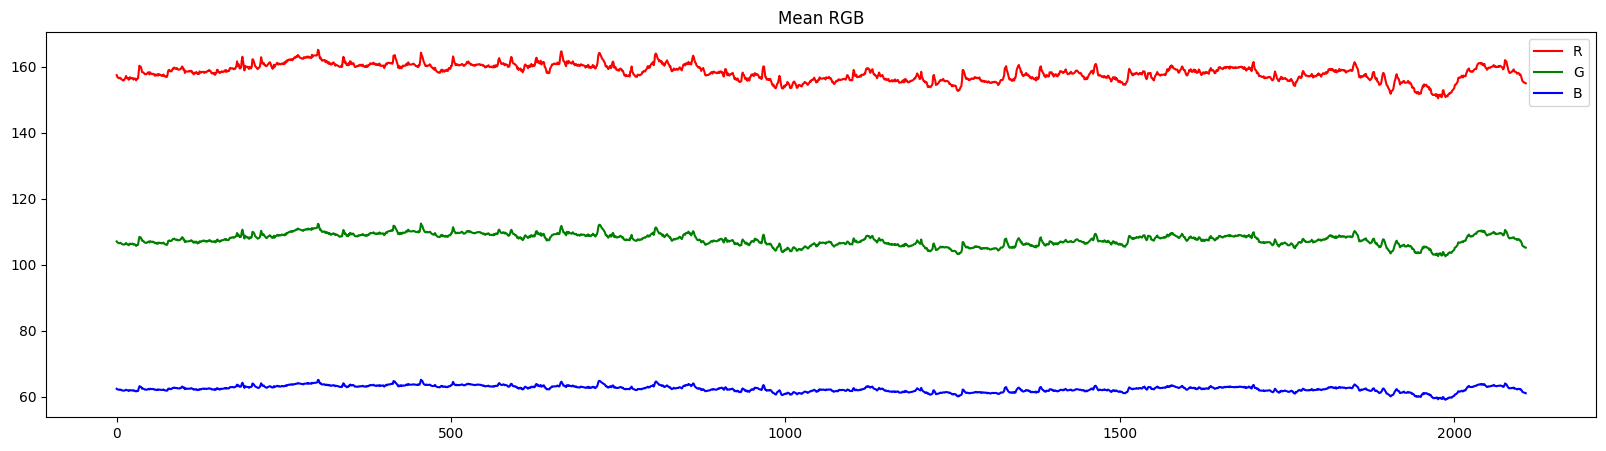

In [9]:
plt.figure(figsize=(20,5))
plt.plot(mean_rgb_mp[:,0], label = 'R', color='red')
plt.plot(mean_rgb_mp[:,1], label = 'G', color='green')
plt.plot(mean_rgb_mp[:,2], label = 'B', color='blue')
plt.legend()
plt.title("Mean RGB")
plt.show()

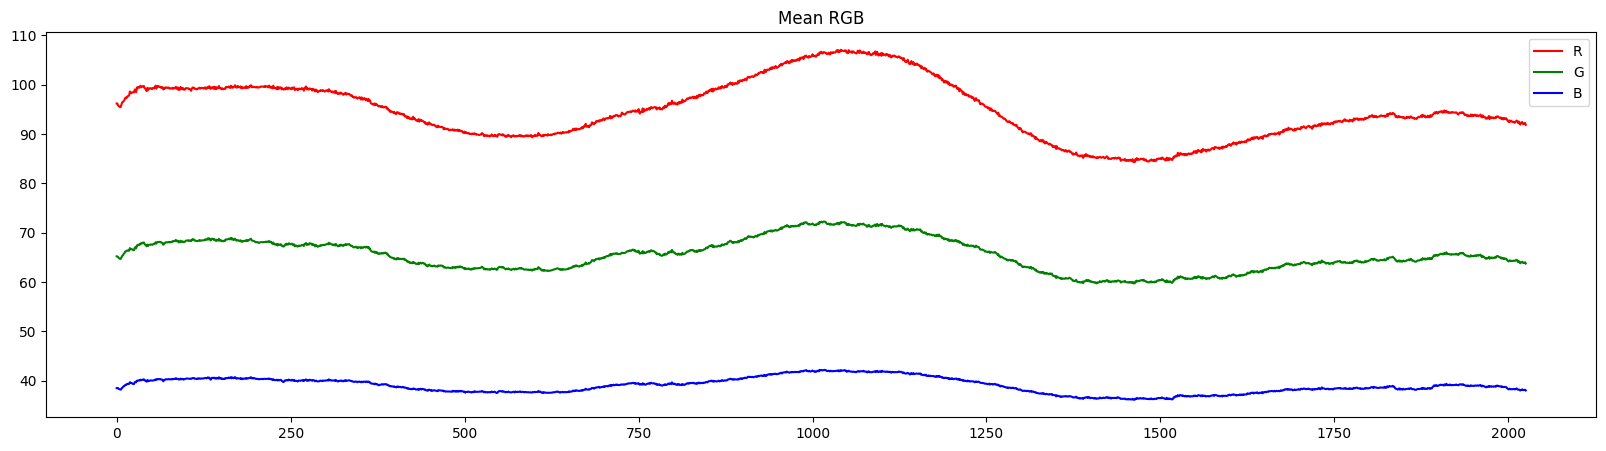

In [16]:
plt.figure(figsize=(20,5))
plt.plot(mean_rgb_dlib[:,0], label = 'R', color='red')
plt.plot(mean_rgb_dlib[:,1], label = 'G', color='green')
plt.plot(mean_rgb_dlib[:,2], label = 'B', color='blue')
plt.legend()
plt.title("Mean RGB")
plt.show()

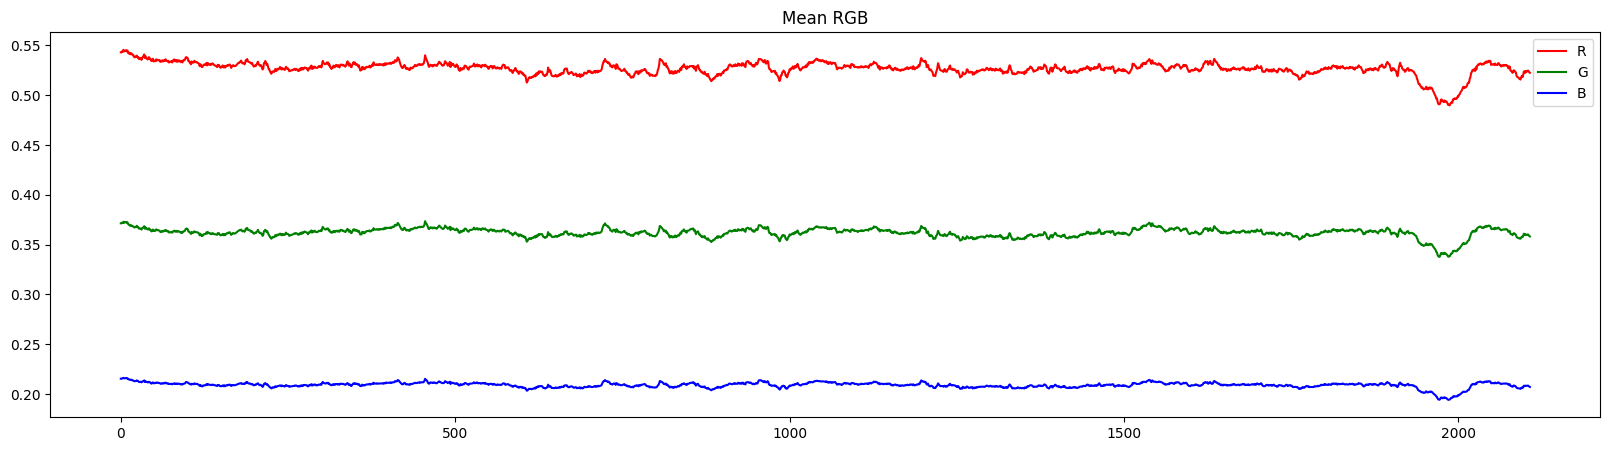

In [10]:
plt.figure(figsize=(20,5))
plt.plot(mean_rgb_ycrcb[:,0], label = 'R', color='red')
plt.plot(mean_rgb_ycrcb[:,1], label = 'G', color='green')
plt.plot(mean_rgb_ycrcb[:,2], label = 'B', color='blue')
plt.legend()
plt.title("Mean RGB")
plt.show()

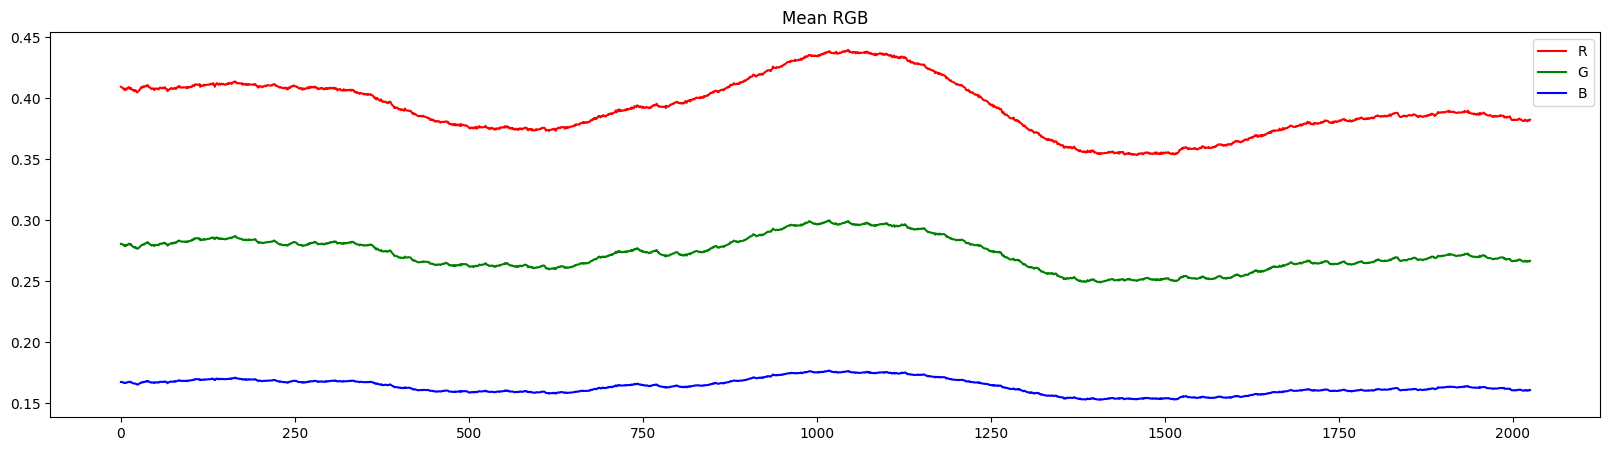

In [18]:
plt.figure(figsize=(20,5))
plt.plot(mean_rgb_hsv[:,0], label = 'R', color='red')
plt.plot(mean_rgb_hsv[:,1], label = 'G', color='green')
plt.plot(mean_rgb_hsv[:,2], label = 'B', color='blue')
plt.legend()
plt.title("Mean RGB")
plt.show()

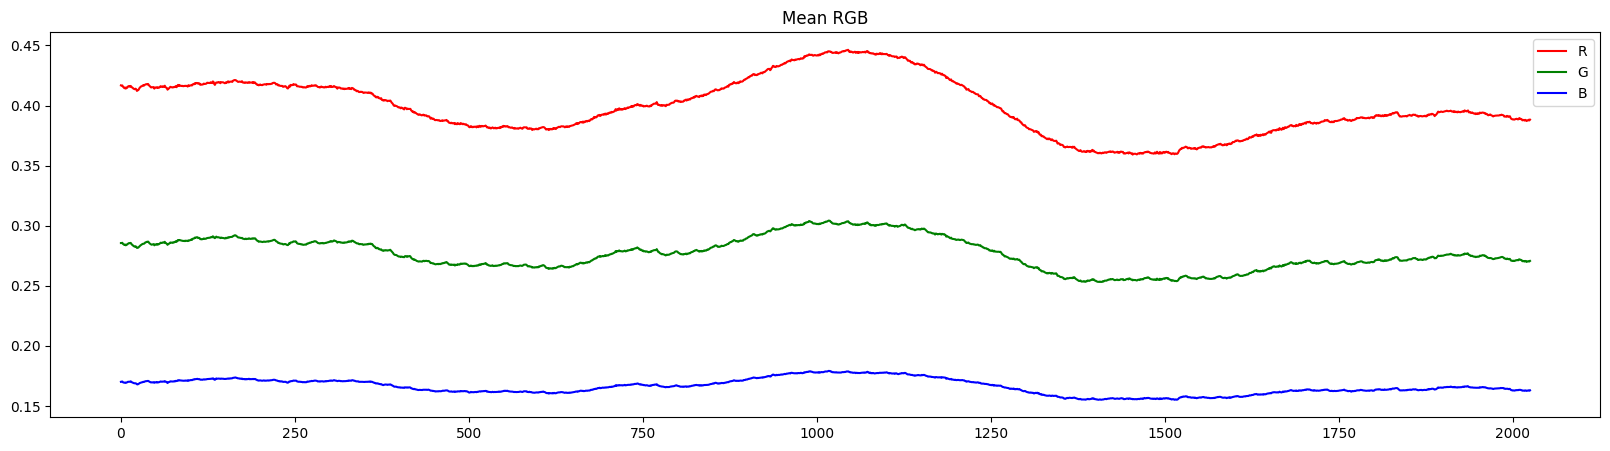

In [19]:
plt.figure(figsize=(20,5))
plt.plot(mean_rgb_hscrcb[:,0], label = 'R', color='red')
plt.plot(mean_rgb_hscrcb[:,1], label = 'G', color='green')
plt.plot(mean_rgb_hscrcb[:,2], label = 'B', color='blue')
plt.legend()
plt.title("Mean RGB")
plt.show()

#### POS

In [21]:
l = int(fps * 1.6)
print(f"Window length: {l}")
rPPG_signals_mp = np.zeros(mean_rgb_mp.shape[0])
print(f"rPPG_signals shape: {rPPG_signals_mp.shape}")

Window length: 48
rPPG_signals shape: (2026,)


In [22]:
for t in range (0, mean_rgb_mp.shape[0] - l):

    ## CREATE C DATA
    C = mean_rgb_mp[t:t+l-1,:].T

    # print(f"C shape: {C.shape}")
    # print (f"C: \n{C}")

    ## CREATE TEMPORAL NORMALIZATION

    mean_color = np.mean(C, axis=1)

    # print(f"Shape of mean color: {mean_color.shape}")
    # print(f"Mean Color: {mean_color}")

    diag_mean_color = np.diag(mean_color)

    # print(f"Shape of diag mean color: {diag_mean_color.shape}")
    # print(f"Diag Mean Color: \n{diag_mean_color}")

    diag_mean_color_inv = np.linalg.inv(diag_mean_color)
    # print(f"Shape of diag mean color inv: {diag_mean_color_inv.shape}")
    # print(f"Diag Mean Color Inv: \n{diag_mean_color_inv}")

    Cn = np.matmul(diag_mean_color_inv, C)
    # print(f"Cn Shape: {Cn.shape}")



    ##FROM 3D TO 2D

    projection_matrix = np.array([[0, 1, -1], [-2, 1, 1]]) 

    S= np.matmul(projection_matrix, Cn)
    # print(f"Shape of S: {S.shape}")

    ##FROM 2D TO 1D

    std = np.array([1, np.std(S[0,:]) / np.std(S[1,:])])
    # print(f"Shape of std: {std.shape}")
    # print(f"std: {std}")

    P = np.matmul(std, S)
    # print(f"Shape of P: {P.shape}")

    # plt.figure(figsize=(20,5))
    # plt.plot(P)

    ## OVERLAPPING

    epsilon = 1e-8  # Small value to avoid division by zero
    rPPG_signals_mp[t:t+l-1] = rPPG_signals_mp[t:t+l-1] + (P - np.mean(P)) / (np.std(P) + epsilon)



    # break



In [23]:
l = int(fps * 1.6)
rPPG_signals_dlib = np.zeros(mean_rgb_dlib.shape[0])

for t in range (0, mean_rgb_mp.shape[0] - l):

    ## CREATE C DATA
    C = mean_rgb_mp[t:t+l-1,:].T

    # print(f"C shape: {C.shape}")
    # print (f"C: \n{C}")

    ## CREATE TEMPORAL NORMALIZATION

    mean_color = np.mean(C, axis=1)

    # print(f"Shape of mean color: {mean_color.shape}")
    # print(f"Mean Color: {mean_color}")

    diag_mean_color = np.diag(mean_color)

    # print(f"Shape of diag mean color: {diag_mean_color.shape}")
    # print(f"Diag Mean Color: \n{diag_mean_color}")

    diag_mean_color_inv = np.linalg.inv(diag_mean_color)
    # print(f"Shape of diag mean color inv: {diag_mean_color_inv.shape}")
    # print(f"Diag Mean Color Inv: \n{diag_mean_color_inv}")

    Cn = np.matmul(diag_mean_color_inv, C)
    # print(f"Cn Shape: {Cn.shape}")



    ##FROM 3D TO 2D

    projection_matrix = np.array([[0, 1, -1], [-2, 1, 1]]) 

    S= np.matmul(projection_matrix, Cn)
    # print(f"Shape of S: {S.shape}")

    ##FROM 2D TO 1D

    std = np.array([1, np.std(S[0,:]) / np.std(S[1,:])])
    # print(f"Shape of std: {std.shape}")
    # print(f"std: {std}")

    P = np.matmul(std, S)
    # print(f"Shape of P: {P.shape}")

    # plt.figure(figsize=(20,5))
    # plt.plot(P)

    ## OVERLAPPING

    epsilon = 1e-8  # Small value to avoid division by zero
    rPPG_signals_dlib[t:t+l-1] = rPPG_signals_dlib[t:t+l-1] + (P - np.mean(P)) / (np.std(P) + epsilon)



    # break



In [24]:
l = int(fps * 1.6)
rPPG_signals_ycrcb = np.zeros(mean_rgb_ycrcb.shape[0])

for t in range (0, mean_rgb_mp.shape[0] - l):

    ## CREATE C DATA
    C = mean_rgb_mp[t:t+l-1,:].T

    # print(f"C shape: {C.shape}")
    # print (f"C: \n{C}")

    ## CREATE TEMPORAL NORMALIZATION

    mean_color = np.mean(C, axis=1)

    # print(f"Shape of mean color: {mean_color.shape}")
    # print(f"Mean Color: {mean_color}")

    diag_mean_color = np.diag(mean_color)

    # print(f"Shape of diag mean color: {diag_mean_color.shape}")
    # print(f"Diag Mean Color: \n{diag_mean_color}")

    diag_mean_color_inv = np.linalg.inv(diag_mean_color)
    # print(f"Shape of diag mean color inv: {diag_mean_color_inv.shape}")
    # print(f"Diag Mean Color Inv: \n{diag_mean_color_inv}")

    Cn = np.matmul(diag_mean_color_inv, C)
    # print(f"Cn Shape: {Cn.shape}")



    ##FROM 3D TO 2D

    projection_matrix = np.array([[0, 1, -1], [-2, 1, 1]]) 

    S= np.matmul(projection_matrix, Cn)
    # print(f"Shape of S: {S.shape}")

    ##FROM 2D TO 1D

    std = np.array([1, np.std(S[0,:]) / np.std(S[1,:])])
    # print(f"Shape of std: {std.shape}")
    # print(f"std: {std}")

    P = np.matmul(std, S)
    # print(f"Shape of P: {P.shape}")

    # plt.figure(figsize=(20,5))
    # plt.plot(P)

    ## OVERLAPPING

    epsilon = 1e-8  # Small value to avoid division by zero
    rPPG_signals_ycrcb[t:t+l-1] = rPPG_signals_ycrcb[t:t+l-1] + (P - np.mean(P)) / (np.std(P) + epsilon)



    # break



In [25]:
l = int(fps * 1.6)
rPPG_signals_hsv = np.zeros(mean_rgb_hsv.shape[0])

for t in range (0, mean_rgb_mp.shape[0] - l):

    ## CREATE C DATA
    C = mean_rgb_mp[t:t+l-1,:].T

    # print(f"C shape: {C.shape}")
    # print (f"C: \n{C}")

    ## CREATE TEMPORAL NORMALIZATION

    mean_color = np.mean(C, axis=1)

    # print(f"Shape of mean color: {mean_color.shape}")
    # print(f"Mean Color: {mean_color}")

    diag_mean_color = np.diag(mean_color)

    # print(f"Shape of diag mean color: {diag_mean_color.shape}")
    # print(f"Diag Mean Color: \n{diag_mean_color}")

    diag_mean_color_inv = np.linalg.inv(diag_mean_color)
    # print(f"Shape of diag mean color inv: {diag_mean_color_inv.shape}")
    # print(f"Diag Mean Color Inv: \n{diag_mean_color_inv}")

    Cn = np.matmul(diag_mean_color_inv, C)
    # print(f"Cn Shape: {Cn.shape}")



    ##FROM 3D TO 2D

    projection_matrix = np.array([[0, 1, -1], [-2, 1, 1]]) 

    S= np.matmul(projection_matrix, Cn)
    # print(f"Shape of S: {S.shape}")

    ##FROM 2D TO 1D

    std = np.array([1, np.std(S[0,:]) / np.std(S[1,:])])
    # print(f"Shape of std: {std.shape}")
    # print(f"std: {std}")

    P = np.matmul(std, S)
    # print(f"Shape of P: {P.shape}")

    # plt.figure(figsize=(20,5))
    # plt.plot(P)

    ## OVERLAPPING

    epsilon = 1e-8  # Small value to avoid division by zero
    rPPG_signals_hsv[t:t+l-1] = rPPG_signals_hsv[t:t+l-1] + (P - np.mean(P)) / (np.std(P) + epsilon)



    # break



In [26]:
l = int(fps * 1.6)
rPPG_signals_hscrcb = np.zeros(mean_rgb_hscrcb.shape[0])

for t in range (0, mean_rgb_mp.shape[0] - l):

    ## CREATE C DATA
    C = mean_rgb_mp[t:t+l-1,:].T

    # print(f"C shape: {C.shape}")
    # print (f"C: \n{C}")

    ## CREATE TEMPORAL NORMALIZATION

    mean_color = np.mean(C, axis=1)

    # print(f"Shape of mean color: {mean_color.shape}")
    # print(f"Mean Color: {mean_color}")

    diag_mean_color = np.diag(mean_color)

    # print(f"Shape of diag mean color: {diag_mean_color.shape}")
    # print(f"Diag Mean Color: \n{diag_mean_color}")

    diag_mean_color_inv = np.linalg.inv(diag_mean_color)
    # print(f"Shape of diag mean color inv: {diag_mean_color_inv.shape}")
    # print(f"Diag Mean Color Inv: \n{diag_mean_color_inv}")

    Cn = np.matmul(diag_mean_color_inv, C)
    # print(f"Cn Shape: {Cn.shape}")



    ##FROM 3D TO 2D

    projection_matrix = np.array([[0, 1, -1], [-2, 1, 1]]) 

    S= np.matmul(projection_matrix, Cn)
    # print(f"Shape of S: {S.shape}")

    ##FROM 2D TO 1D

    std = np.array([1, np.std(S[0,:]) / np.std(S[1,:])])
    # print(f"Shape of std: {std.shape}")
    # print(f"std: {std}")

    P = np.matmul(std, S)
    # print(f"Shape of P: {P.shape}")

    # plt.figure(figsize=(20,5))
    # plt.plot(P)

    ## OVERLAPPING

    epsilon = 1e-8  # Small value to avoid division by zero
    rPPG_signals_hscrcb[t:t+l-1] = rPPG_signals_hscrcb[t:t+l-1] + (P - np.mean(P)) / (np.std(P) + epsilon)



    # break



#### GRGB

In [14]:
R = mean_rgb_mp[:, 0]
G = mean_rgb_mp[:, 1]
B = mean_rgb_mp[:, 2]

GRGB_signal_mp = (G/R) + (G/B)

# GRGB_signal.shape

In [15]:
R = mean_rgb_ycrcb[:, 0]
G = mean_rgb_ycrcb[:, 1]
B = mean_rgb_ycrcb[:, 2]

GRGB_signal_ycrcb = (G/R) + (G/B)

#### Converting Timestamps

In [16]:
timestamps = []

for file_name in png_list:
    # Use regex to extract digits following 'Image' and before '.png'
    match = re.search(r'Image(\d+)\.png', file_name)
    if match:
        timestamps.append(match.group(1))

# print(len(timestamps))

durations = []
for ts in timestamps:
    # Convert nanoseconds to seconds
    timestamp_sec = int(ts) / 1e9

    durations.append(timestamp_sec)


# Print formatted times and original timestamps
# print(len(formatted_times))
first_duration = durations[0]
video_durations = [duration - first_duration for duration in durations]
print(video_durations[:15])
# print(timestamps[:5])

[0.0, 0.03331398963928223, 0.06665873527526855, 0.10000276565551758, 0.1333167552947998, 0.16666078567504883, 0.20000576972961426, 0.23331999778747559, 0.2666640281677246, 0.30000782012939453, 0.33332204818725586, 0.3666670322418213, 0.3999807834625244, 0.43332481384277344, 0.46666884422302246]


#### rPPG Signal Plot

Shape of rPPG_signals: (2026,)


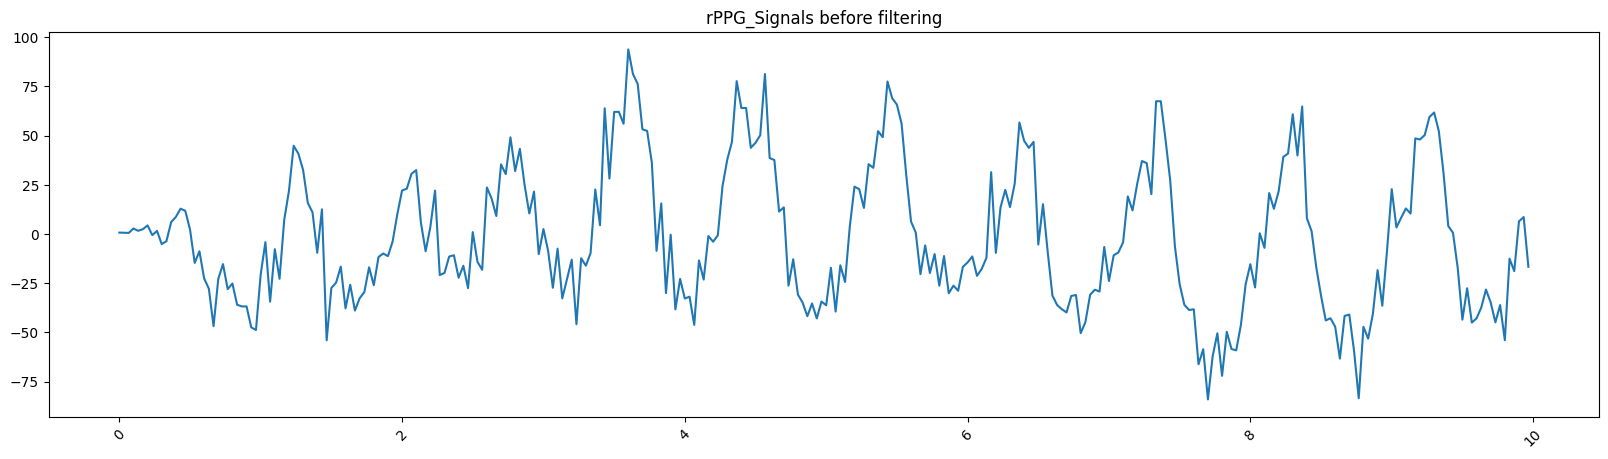

In [29]:
from matplotlib.ticker import MaxNLocator


print(f"Shape of rPPG_signals: {rPPG_signals_mp.shape}")
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, rPPG_signals)
plt.plot(video_durations[:300], rPPG_signals_mp[:300])

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability

plt.title(f"rPPG_Signals before filtering")
plt.show()

Shape of GRGB_signals: (2108,)


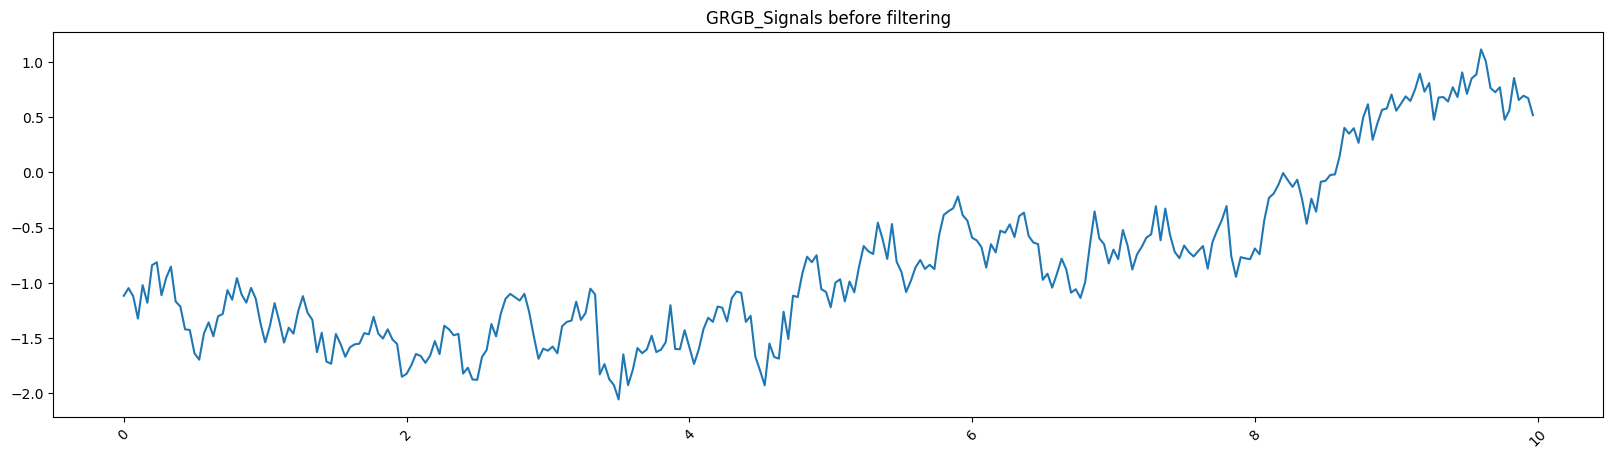

In [17]:
from matplotlib.ticker import MaxNLocator


GRGB_signal_mp = (GRGB_signal_mp-np.mean(GRGB_signal_mp))/np.std(GRGB_signal_mp)

print(f"Shape of GRGB_signals: {GRGB_signal_mp.shape}")
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, GRGB_signal)
plt.plot(video_durations[:300], GRGB_signal_mp[:300])

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability

plt.title(f"GRGB_Signals before filtering")
plt.show()

Bandpass Filter

Shape of rPPG_signals: (2026,)
[ 0.02964905  0.06479299  0.11209954 ... -0.12687417 -0.08122237
 -0.02727499]


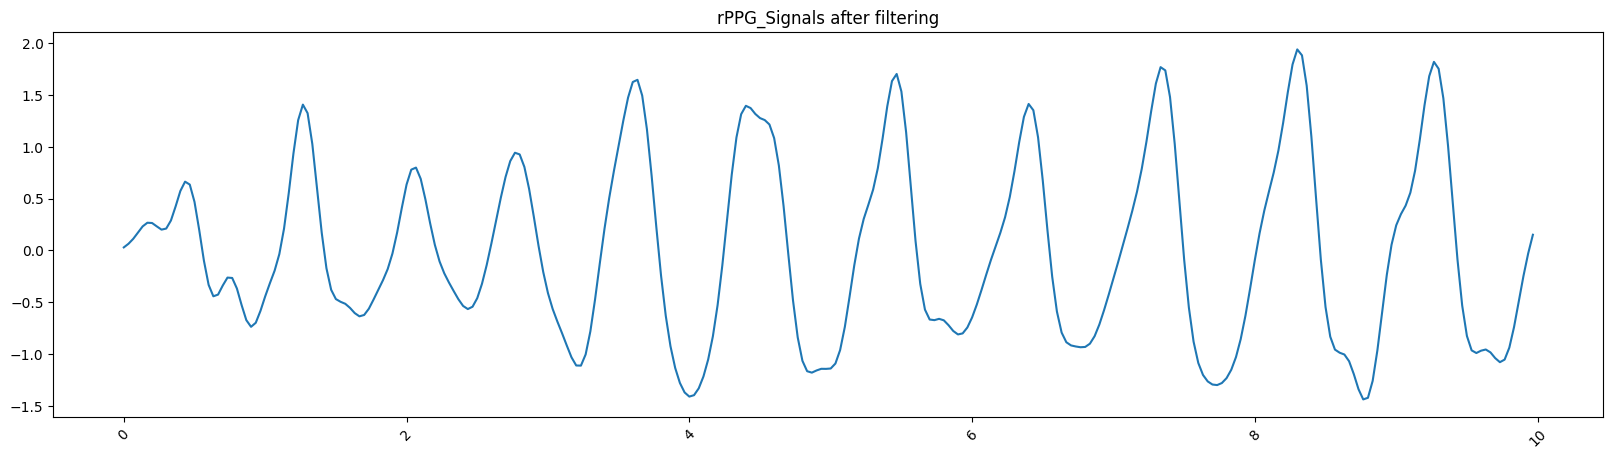

In [31]:
from scipy import signal

lowcut = 0.65
highcut = 4

b, a = signal.butter(6, [lowcut, highcut], btype='bandpass', fs=fps)
rPPG_filtered_mp = signal.filtfilt(b, a, rPPG_signals_mp)

#standardization
rPPG_filtered_mp = (rPPG_filtered_mp-np.mean(rPPG_filtered_mp))/np.std(rPPG_filtered_mp)

print(f"Shape of rPPG_signals: {rPPG_filtered_mp.shape}")
print(rPPG_filtered_mp)
plt.figure(figsize=(20,5))
plt.plot(video_durations[:300], rPPG_filtered_mp[:300])
# plt.plot(rPPG_filtered)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title(f"rPPG_Signals after filtering")
plt.show()

Shape of GRGB_signals: (2108,)
[ 0.06789696 -0.07022964 -0.11958937 ... -1.47587702 -0.86438657
 -0.22822237]


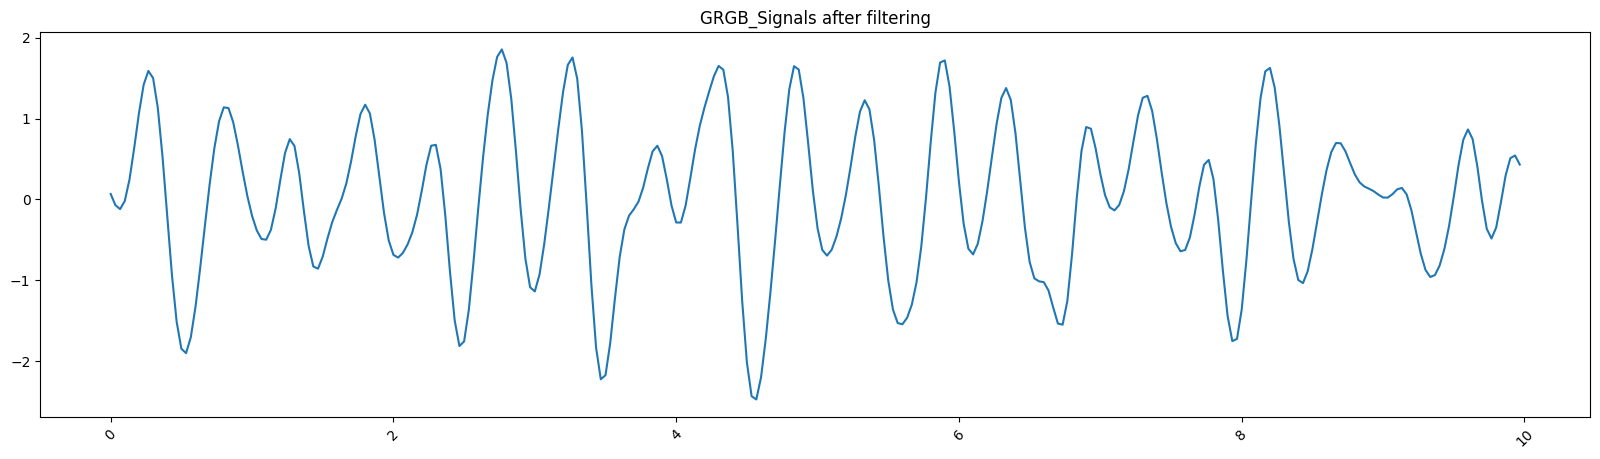

In [18]:
from scipy import signal

lowcut = 0.65
highcut = 4

b, a = signal.butter(6, [lowcut, highcut], btype='bandpass', fs=fps)
GRGB_filtered_mp = signal.filtfilt(b, a, GRGB_signal_mp)

#standardization
GRGB_filtered_mp = (GRGB_filtered_mp-np.mean(GRGB_filtered_mp))/np.std(GRGB_filtered_mp)

print(f"Shape of GRGB_signals: {GRGB_filtered_mp.shape}")
print(GRGB_filtered_mp)
plt.figure(figsize=(20,5))
plt.plot(video_durations[:300], GRGB_filtered_mp[:300])
# plt.plot(GRGB_filtered)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title(f"GRGB_Signals after filtering")
plt.show()

Shape of GRGB_signals: (2108,)
[ 0.08412082 -0.26393904 -0.46998607 ... -2.2242827  -1.33033492
 -0.37459371]


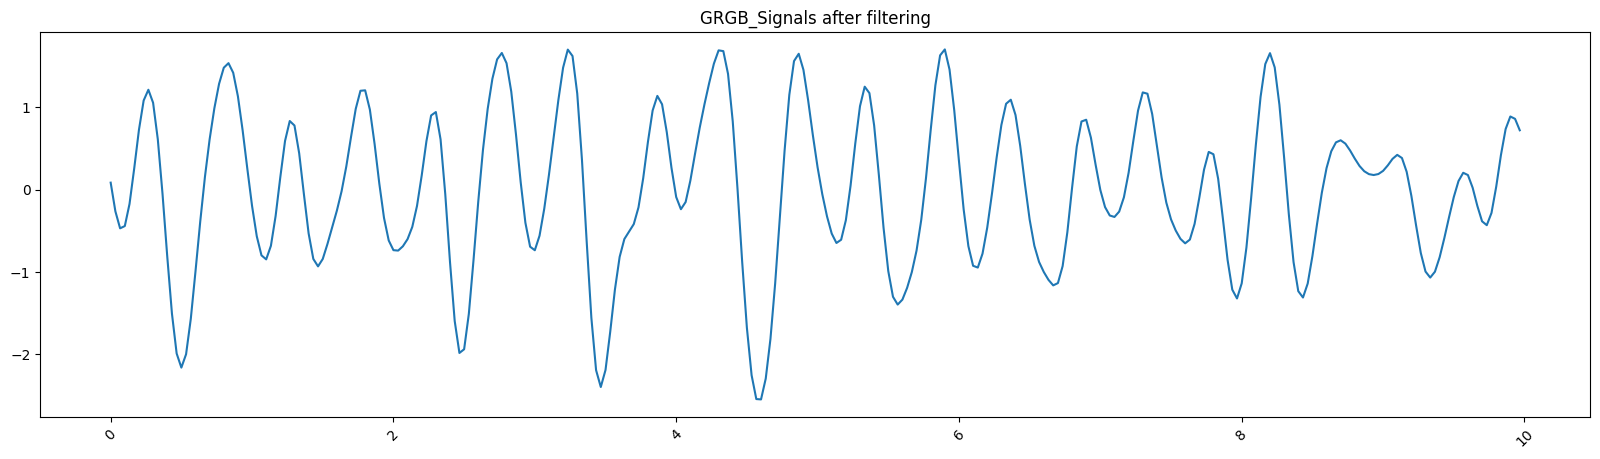

In [19]:
from scipy import signal

lowcut = 0.65
highcut = 4

b, a = signal.butter(6, [lowcut, highcut], btype='bandpass', fs=fps)
GRGB_filtered_ycrcb = signal.filtfilt(b, a, GRGB_signal_ycrcb)

#standardization
GRGB_filtered_ycrcb = (GRGB_filtered_ycrcb-np.mean(GRGB_filtered_ycrcb))/np.std(GRGB_filtered_ycrcb)

print(f"Shape of GRGB_signals: {GRGB_filtered_ycrcb.shape}")
print(GRGB_filtered_ycrcb)
plt.figure(figsize=(20,5))
plt.plot(video_durations[:300], GRGB_filtered_ycrcb[:300])
# plt.plot(GRGB_filtered)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title(f"GRGB_Signals after filtering")
plt.show()

#### Compare with groundtruth

[0.0, 0.016015291213989258, 0.03208422660827637, 0.04798531532287598, 0.0639653205871582, 0.0799872875213623, 0.11197638511657715, 0.12797904014587402, 0.14397907257080078, 0.1599881649017334, 0.1759631633758545, 0.19196414947509766, 0.20798802375793457, 0.2239680290222168, 0.2399911880493164]
4187


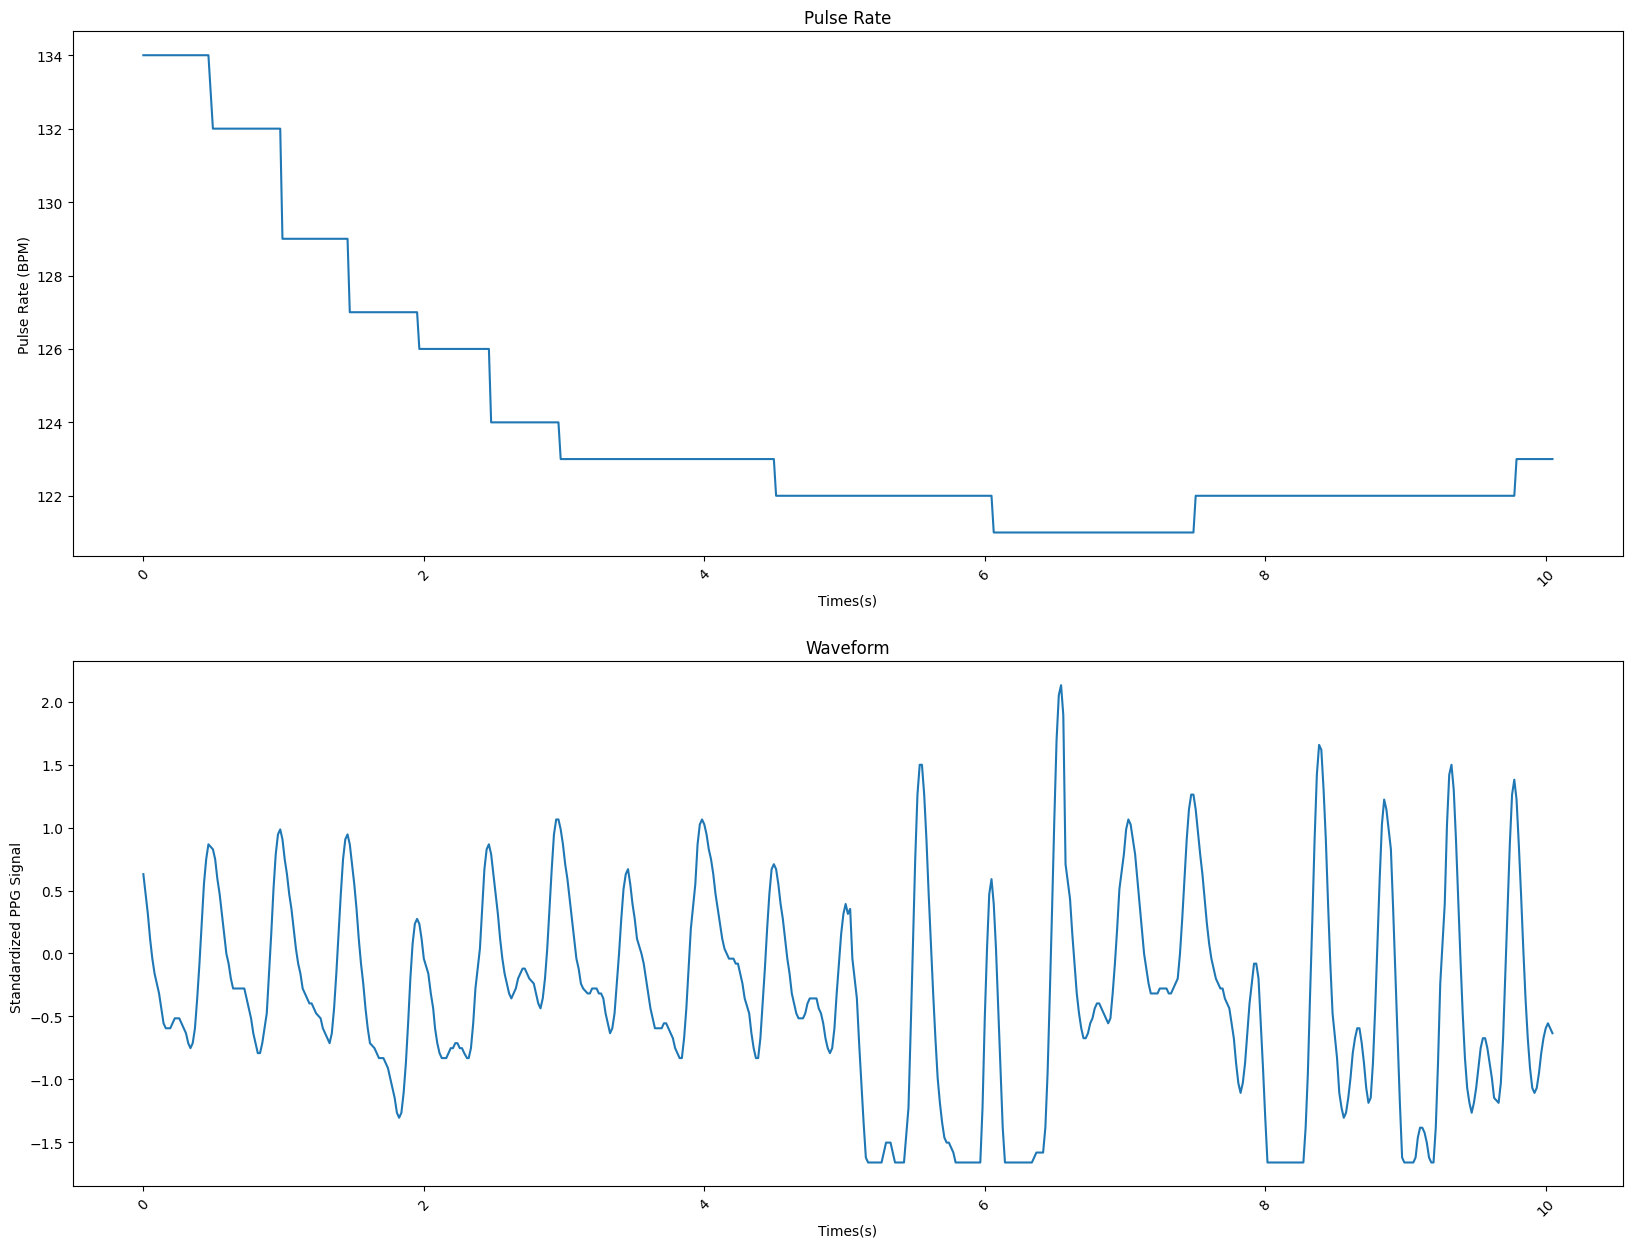

BPM = 134.78934798184858


In [21]:
import json 
from matplotlib.ticker import MaxNLocator

gt_path = dataset_path + subject_name +'/07-02.json'

with open (gt_path, 'r') as file:
    data = json.load(file)

full_package_data = data["/FullPackage"]
image_data = data["/Image"]

timestamps_package = [entry["Timestamp"] for entry in full_package_data]
waveform = [entry["Value"]["waveform"] for entry in full_package_data]
pulseRate = [entry["Value"]["pulseRate"] for entry in full_package_data]
frame_package = [entry["FrameID"] for entry in full_package_data]
waveform = (waveform-np.mean(waveform))/np.std(waveform)

# print(timestamps_package[:5])

# Converting Timestamps
duration_packages = []
for ts in timestamps_package:
    # Convert nanoseconds to seconds
    timestamp_sec = int(ts) / 1e9
    
    duration_packages.append(timestamp_sec)


first_duration_package = duration_packages[0]
oxymeter_durations = [duration_package - first_duration_package for duration_package in duration_packages]
print(oxymeter_durations[:15])
print(len(waveform))

plt.figure(figsize=(20,15))
# plt.subplot(2,1,1)
# plt.plot(pulseRate)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
# plt.xticks(rotation=45)  # Rotate labels for better readability

# plt.subplot(2,1,2)
# plt.plot(waveform)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
# plt.xticks(rotation=45)  # Rotate labels for better readability
# plt.show()

#plotting against converted timestamps
# Plot pulse rate
plt.subplot(2, 1, 1)
plt.plot(oxymeter_durations[:600], pulseRate[:600])
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title("Pulse Rate")
plt.xlabel("Times(s)")  # Label x-axis
plt.ylabel("Pulse Rate (BPM)")  # Label y-axis with unit

# Plot waveform
plt.subplot(2, 1, 2)
plt.plot(oxymeter_durations[:600], waveform[:600])
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title("Waveform")
plt.xlabel("Times(s)")  # Label x-axis
plt.ylabel("Standardized PPG Signal ")  # Label y-axis with unit
plt.show()

print(f"BPM = {np.mean(pulseRate)}")
# print(len(timestamps_package))
# print(len(frame_package))
# print(len(timestamps))
# print(len(frame))

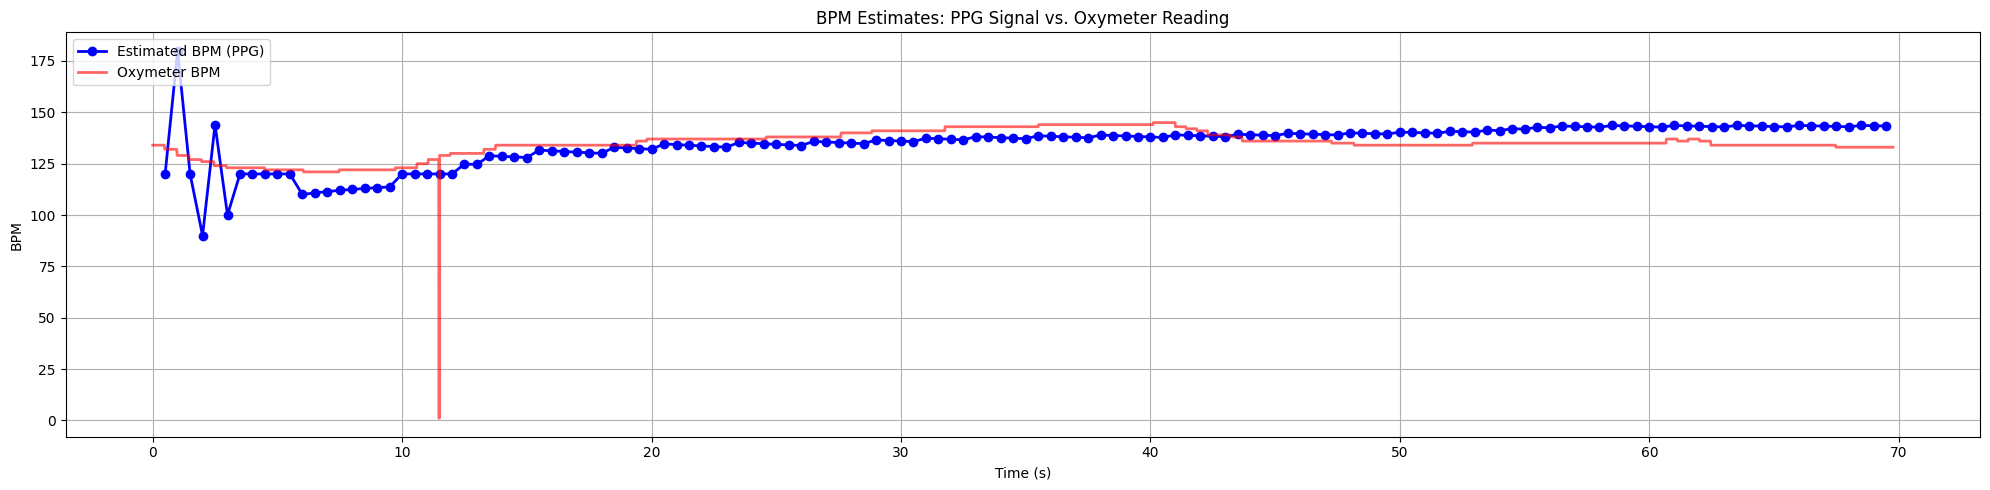

Window 1 (from 0s to 0.50s): BPM = 120.00
Window 2 (from 0s to 1.00s): BPM = 180.00
Window 3 (from 0s to 1.50s): BPM = 120.00
Window 4 (from 0s to 2.00s): BPM = 90.00
Window 5 (from 0s to 2.50s): BPM = 144.00
Window 6 (from 0s to 3.00s): BPM = 100.00
Window 7 (from 0s to 3.50s): BPM = 120.00
Window 8 (from 0s to 4.00s): BPM = 120.00
Window 9 (from 0s to 4.50s): BPM = 120.00
Window 10 (from 0s to 5.00s): BPM = 120.00
Window 11 (from 0s to 5.50s): BPM = 120.00
Window 12 (from 0s to 6.00s): BPM = 110.00
Window 13 (from 0s to 6.50s): BPM = 110.77
Window 14 (from 0s to 7.00s): BPM = 111.43
Window 15 (from 0s to 7.50s): BPM = 112.00
Window 16 (from 0s to 8.00s): BPM = 112.50
Window 17 (from 0s to 8.50s): BPM = 112.94
Window 18 (from 0s to 9.00s): BPM = 113.33
Window 19 (from 0s to 9.50s): BPM = 113.68
Window 20 (from 0s to 10.00s): BPM = 120.00
Window 21 (from 0s to 10.50s): BPM = 120.00
Window 22 (from 0s to 11.00s): BPM = 120.00
Window 23 (from 0s to 11.50s): BPM = 120.00
Window 24 (from 0

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Parameters
fs = 60  # Sampling rate in Hz (samples per second)
step_time = 0.5 # Step size for window expansion in seconds
step_size = int(step_time * fs)  # Step size in samples

# Store the BPM estimates
bpm_estimates = []
time_window = []

# Expanding window approach for PSD and BPM calculation
for end in range(step_size, len(waveform) + 1, step_size):
    # Window from 0 to the current end point
    window_trace = waveform[:end]
    
    # PSD calculation using Welch's method
    freq_PPG, psd_PPG = welch(window_trace, fs=fs, window='flattop', nperseg=len(window_trace))
    
    # Find the frequency with the maximum power
    max_freq_PPG = freq_PPG[np.argmax(psd_PPG)]
    
    # Convert the frequency to BPM
    PPG_bpm = max_freq_PPG * 60
    bpm_estimates.append(PPG_bpm)
    
    # Store the current time window (in seconds)
    time_window.append(end / fs)

# Plotting the BPM estimates and oxymeter BPM on the same y-axis
plt.figure(figsize=(20, 5))

# Plot BPM estimates from the PPG signal
plt.plot(time_window, bpm_estimates, marker='o', color='blue', label='Estimated BPM (PPG)', linewidth=2)

# Plot the oxymeter readings for comparison
plt.plot(np.arange(len(pulseRate)) / fs, pulseRate, color='red', alpha=0.6, label='Oxymeter BPM', linewidth=2)

# Configure plot
plt.title("BPM Estimates: PPG Signal vs. Oxymeter Reading")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend(loc="upper left")
plt.grid()

# Show plot
plt.tight_layout()
plt.show()

# Print the BPM estimates
for i, bpm in enumerate(bpm_estimates):
    print(f"Window {i+1} (from 0s to {time_window[i]:.2f}s): BPM = {bpm:.2f}")


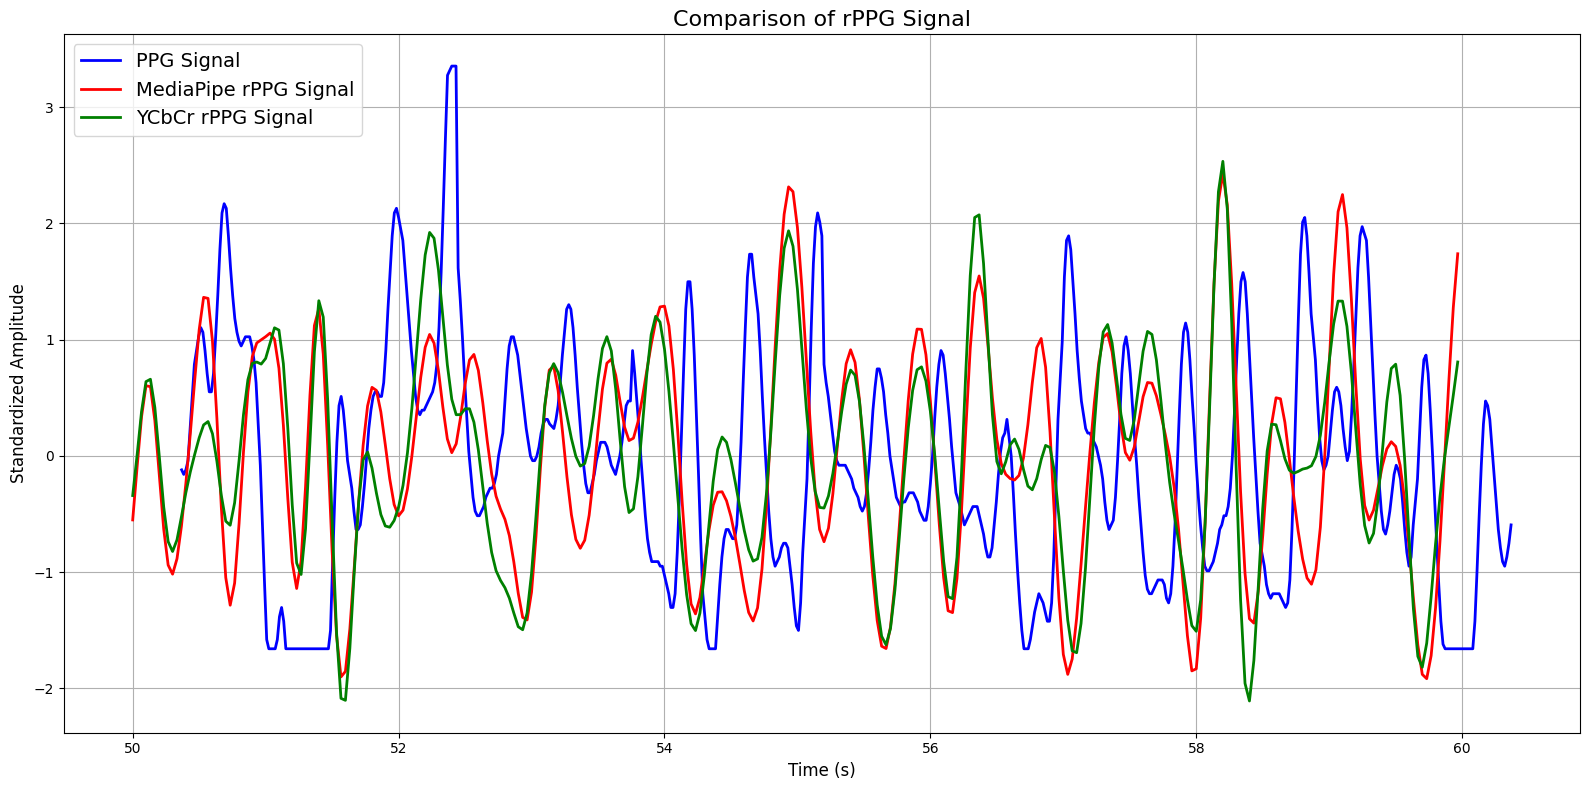

In [42]:
# Plotting the BPM estimates and oxymeter BPM on the same y-axis
plt.figure(figsize=(16, 8))

# Plot BPM estimates from the PPG signal
plt.plot(oxymeter_durations[3000:3600], waveform[3000:3600], color='blue', label='PPG Signal', linewidth=2)

# Plot the oxymeter readings for comparison
plt.plot(video_durations[1500:1800], GRGB_filtered_mp[1500:1800], color='red', label='MediaPipe rPPG Signal', linewidth=2)

# plt.plot(video_durations, rPPG_filtered_dlib, color='green', label='POS rPPG Signal', linewidth=2)

plt.plot(video_durations[1500:1800], GRGB_filtered_ycrcb[1500:1800], color='green', label='YCbCr rPPG Signal', linewidth=2)

# plt.plot(video_durations[:150], rPPG_filtered_hsv[:150], color='black', label='POS rPPG Signal', linewidth=2)

# plt.plot(video_durations, rPPG_filtered_hscrcb, color='orange', label='POS rPPG Signal', linewidth=2)


# Configure plot
plt.title("Comparison of rPPG Signal", fontsize=16)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Standardized Amplitude", fontsize=12)
plt.legend(loc="upper left", fontsize=14)
plt.grid()

# Show plot
plt.tight_layout()
plt.show()


#### Estimate BPM

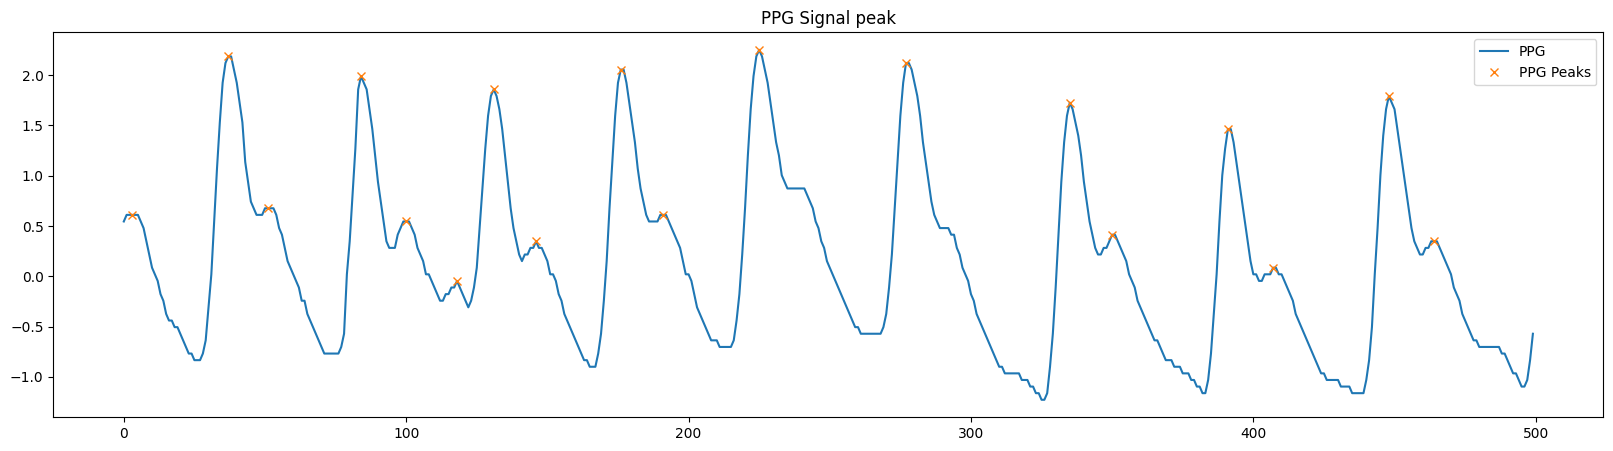

PPG Peaks = 18


In [23]:
from scipy.signal import find_peaks
PPG_peaks, _ = find_peaks(waveform[:500])

plt.figure(figsize=(20,5))
plt.plot(waveform[:500], label='PPG')
plt.plot(PPG_peaks, waveform[PPG_peaks], "x", label='PPG Peaks')
plt.legend()
plt.title("PPG Signal peak")
plt.show()

print(f"PPG Peaks = {len(PPG_peaks)}")

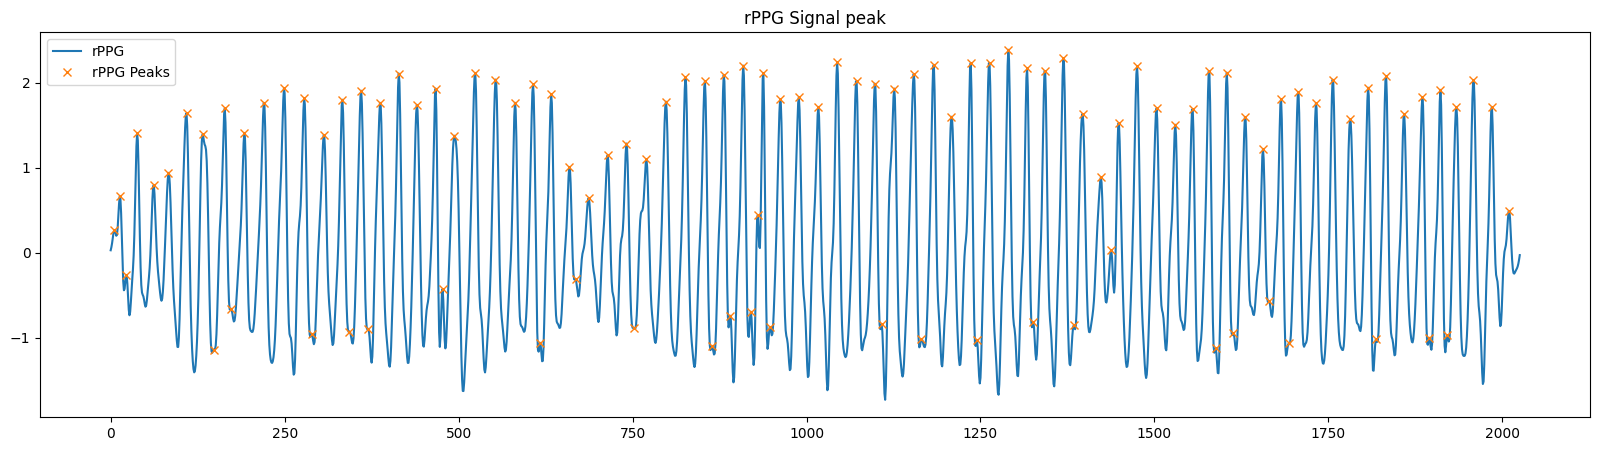

rPPG Peaks = 105


In [24]:
from scipy.signal import find_peaks
rPPG_peaks, _ = find_peaks(rPPG_filtered)

plt.figure(figsize=(20,5))
plt.plot(rPPG_filtered, label='rPPG')
plt.plot(rPPG_peaks, rPPG_filtered[rPPG_peaks], "x", label='rPPG Peaks')
plt.legend()
plt.title("rPPG Signal peak")
plt.show()

print(f"rPPG Peaks = {len(rPPG_peaks[:300])}")

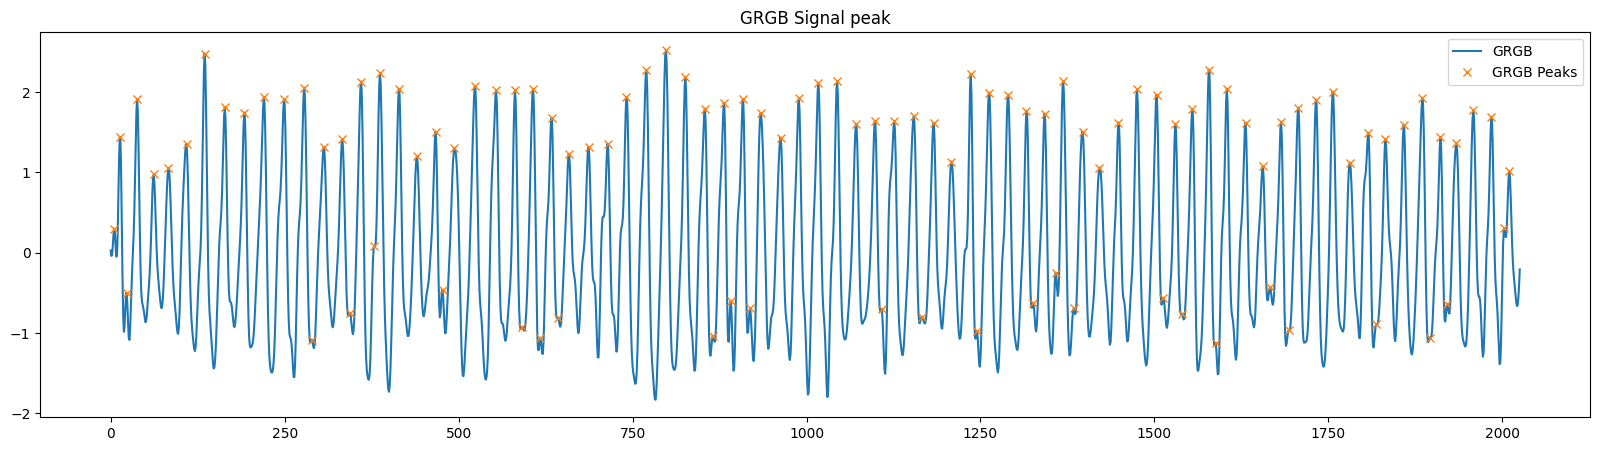

GRGB Peaks = 103


In [25]:
from scipy.signal import find_peaks
GRGB_peaks, _ = find_peaks(GRGB_filtered)

plt.figure(figsize=(20,5))
plt.plot(GRGB_filtered, label='GRGB')
plt.plot(GRGB_peaks, GRGB_filtered[GRGB_peaks], "x", label='GRGB Peaks')
plt.legend()
plt.title("GRGB Signal peak")
plt.show()

print(f"GRGB Peaks = {len(GRGB_peaks)}")

C:\Users\Darren\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 4188 is greater than input length  = 4187, using nperseg = 4187
  warnings.warn('nperseg = {0:d} is greater than input length '


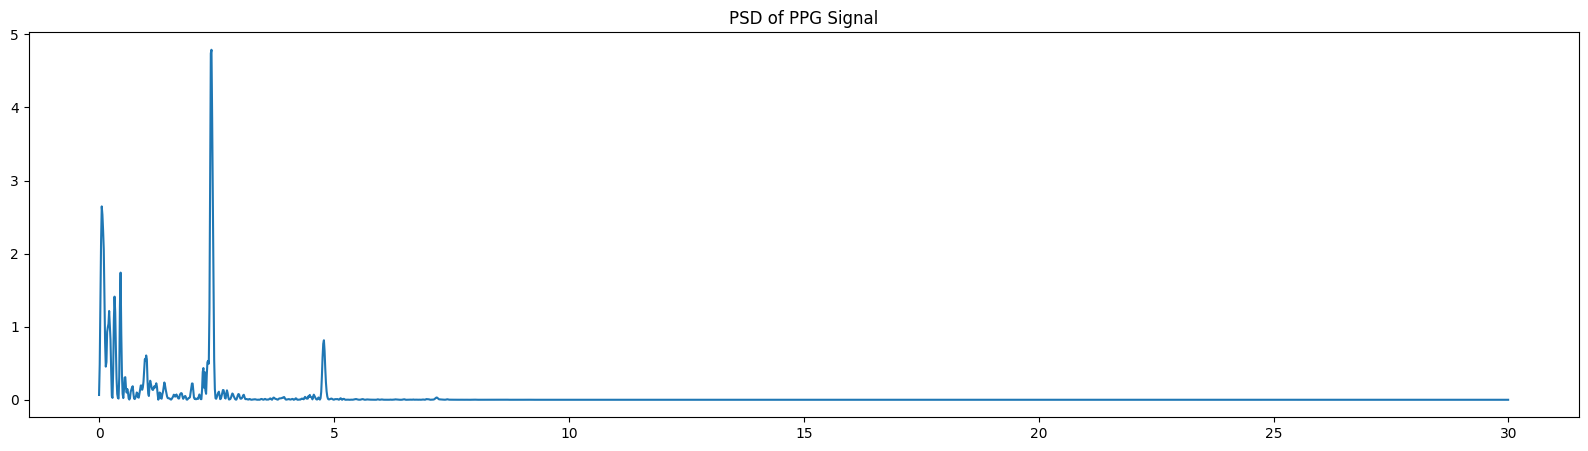

Max Frequency of PPG Signal: 2.3931215667542394
BPM: 143.58729400525436


In [29]:
from scipy.signal import welch

seg_len = (2*waveform.shape[0]) // n_segment + 1

freq_PPG, psd_PPG = welch(waveform, fs=60, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_PPG, psd_PPG)
plt.title("PSD of PPG Signal")
plt.show()

max_freq_PPG =  freq_PPG[np.argmax(psd_PPG)]
print(f"Max Frequency of PPG Signal: {max_freq_PPG}")
PPG_bpm = max_freq_PPG * 60
print(f"BPM: {PPG_bpm}")

C:\Users\Darren\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 2027 is greater than input length  = 2026, using nperseg = 2026
  warnings.warn('nperseg = {0:d} is greater than input length '


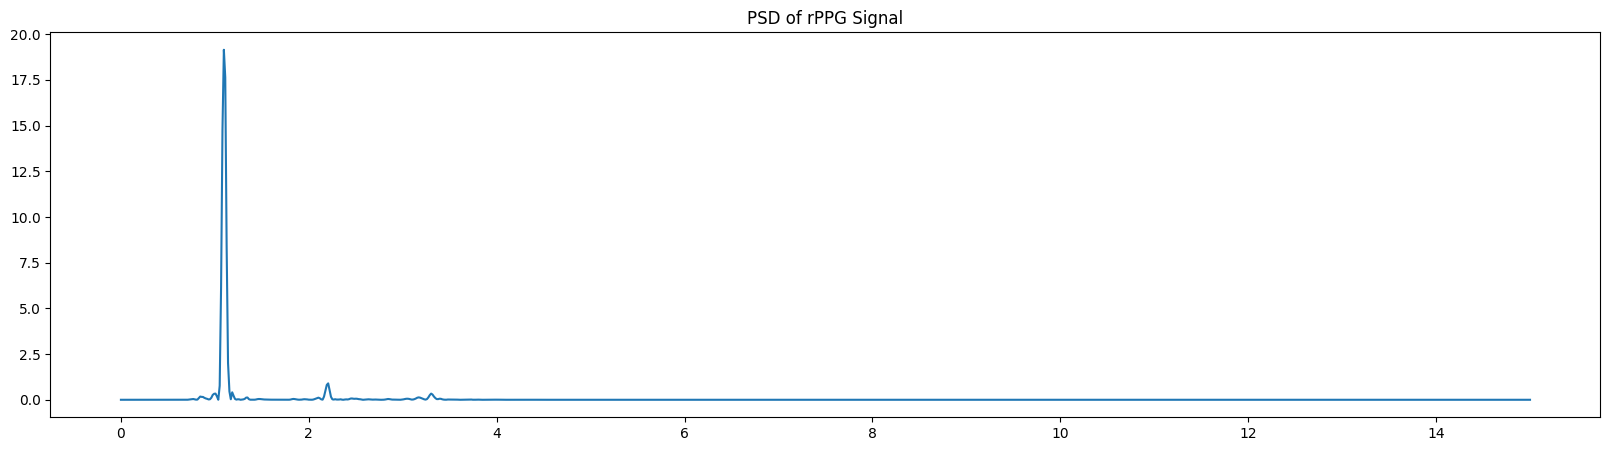

Max Frequency of rPPG Signal: 1.0957551826258638
BPM: 65.74531095755182


In [27]:
from scipy.signal import welch

seg_len = (2*rPPG_filtered.shape[0]) // n_segment + 1

freq_rPPG, psd_rPPG = welch(rPPG_filtered, fs=fps, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_rPPG, psd_rPPG)
plt.title("PSD of rPPG Signal")
plt.show()

max_freq_rPPG =  freq_rPPG[np.argmax(psd_rPPG)]
print(f"Max Frequency of rPPG Signal: {max_freq_rPPG}")
rPPG_bpm = max_freq_rPPG * 60
print(f"BPM: {rPPG_bpm}")

C:\Users\Darren\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 2109 is greater than input length  = 2108, using nperseg = 2108
  warnings.warn('nperseg = {0:d} is greater than input length '


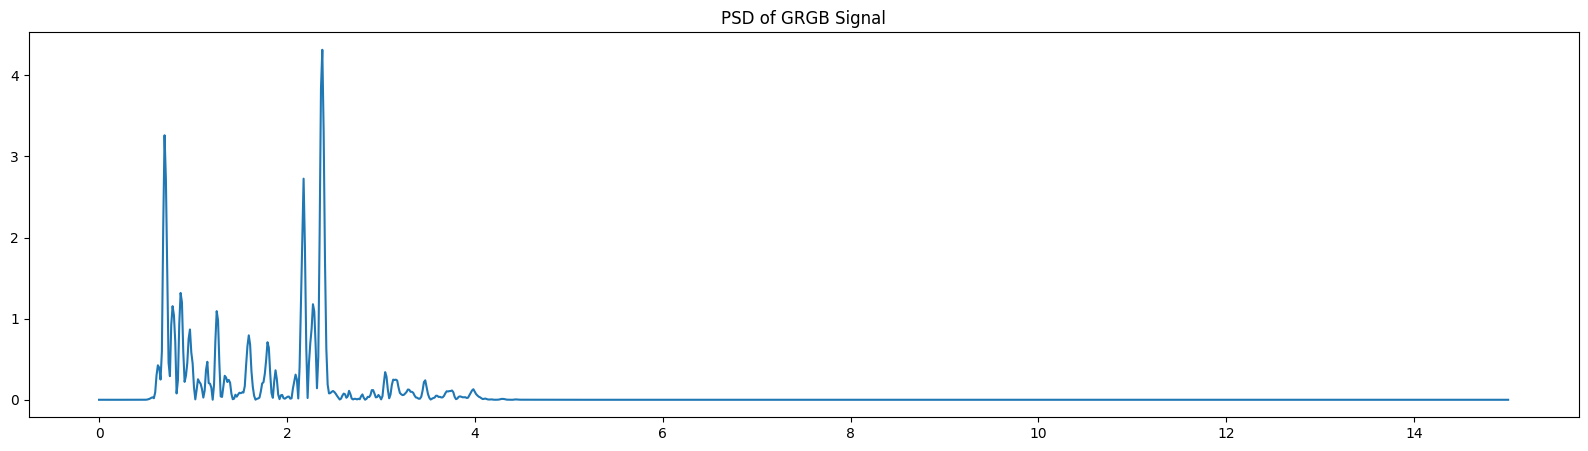

Max Frequency of GRGB Signal: 2.3766603415559775
BPM: 142.59962049335866


In [32]:
from scipy.signal import welch

seg_len = (2*GRGB_filtered_mp.shape[0]) // n_segment + 1

freq_GRGB, psd_GRGB_mp = welch(GRGB_filtered_mp, fs=fps, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_GRGB, psd_GRGB_mp)
plt.title("PSD of GRGB Signal")
plt.show()

max_freq_GRGB =  freq_GRGB[np.argmax(psd_GRGB_mp)]
print(f"Max Frequency of GRGB Signal: {max_freq_GRGB}")
GRGB_bpm = max_freq_GRGB * 60
print(f"BPM: {GRGB_bpm}")

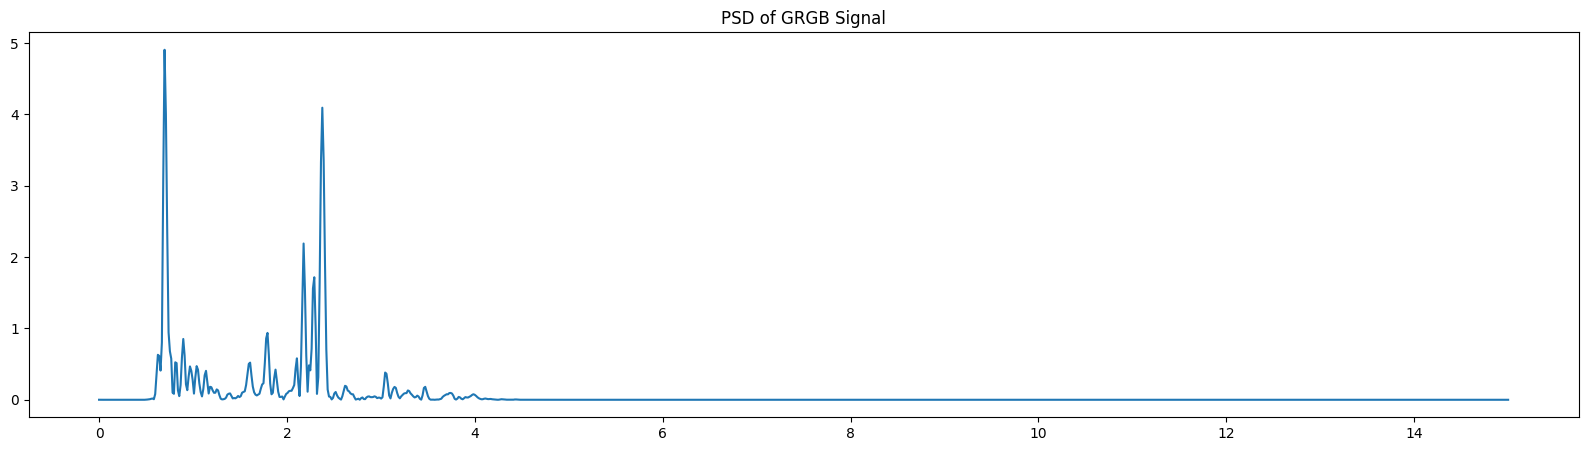

Max Frequency of GRGB Signal: 0.6973434535104365
BPM: 41.84060721062619


In [33]:
from scipy.signal import welch

seg_len = (2*GRGB_filtered_ycrcb.shape[0]) // n_segment + 1

freq_GRGB, psd_GRGB_ycrcb = welch(GRGB_filtered_ycrcb, fs=fps, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_GRGB, psd_GRGB_ycrcb)
plt.title("PSD of GRGB Signal")
plt.show()

max_freq_GRGB =  freq_GRGB[np.argmax(psd_GRGB_ycrcb)]
print(f"Max Frequency of GRGB Signal: {max_freq_GRGB}")
GRGB_bpm = max_freq_GRGB * 60
print(f"BPM: {GRGB_bpm}")

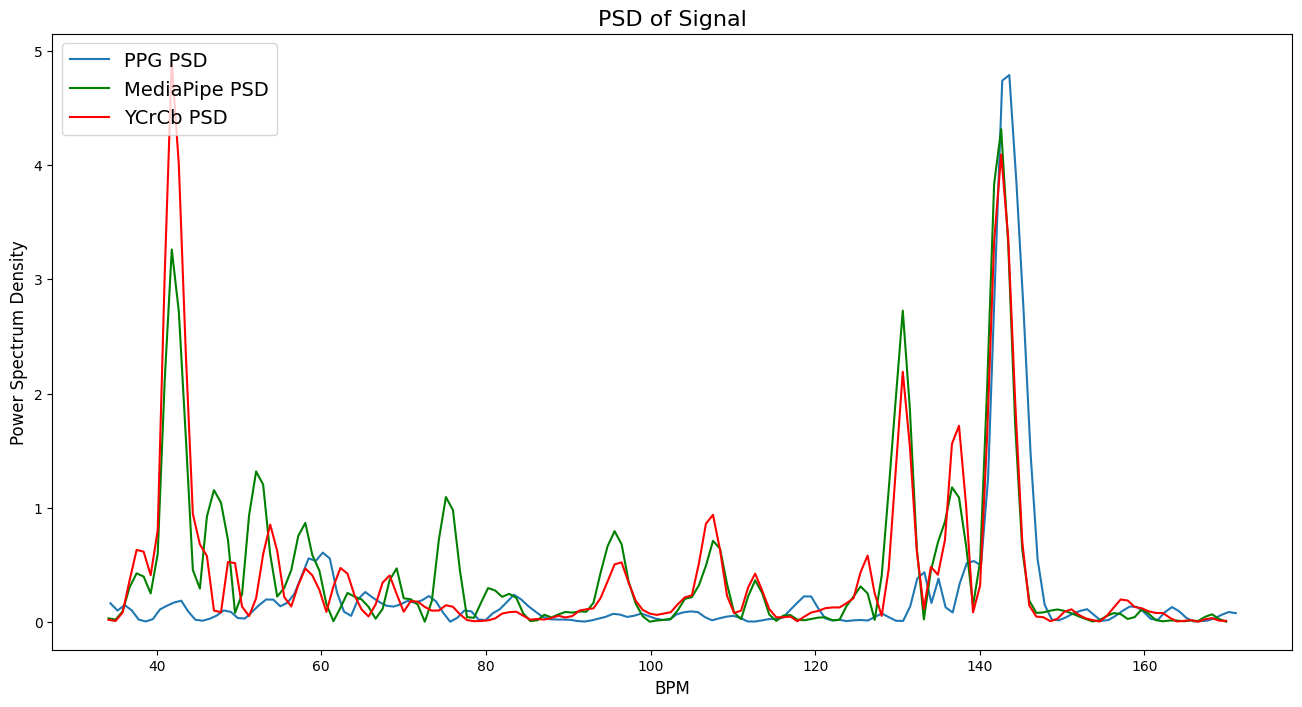

In [38]:
BPM_PPG = freq_PPG * 60
# BPM_rPPG = freq_rPPG * 60
BPM_GRGB = freq_GRGB * 60

plt.figure(figsize=(16,8))
plt.plot(BPM_PPG[40:200], psd_PPG[40:200], label = 'PPG PSD')
plt.plot(BPM_GRGB[40:200], psd_GRGB_mp[40:200], 'g', label = 'MediaPipe PSD' )
plt.plot(BPM_GRGB[40:200], psd_GRGB_ycrcb[40:200], 'r', label = 'YCrCb PSD')
plt.title("PSD of Signal", fontsize=16)
plt.xlabel("BPM", fontsize=12)
plt.ylabel("Power Spectrum Density", fontsize=12)
plt.legend(loc="upper left", fontsize=14)
plt.show()

#### evaluation

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import pandas as pd

# 1. Error Metrics (MAE, RMSE, PCC) for heart rate comparison
def evaluate_hr_metrics(ppg_bpm, rppg_bpm):
    # Ensure both sequences are the same length
    ppg_bpm = np.array(ppg_bpm)
    rppg_bpm = np.array(rppg_bpm)
    
    # Compute error metrics
    mae = mean_absolute_error(ppg_bpm, rppg_bpm)
    rmse = np.sqrt(mean_squared_error(ppg_bpm, rppg_bpm))
    pcc, _ = pearsonr(ppg_bpm, rppg_bpm)
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Pearson Correlation Coefficient (PCC): {pcc}")
    
    return mae, rmse, pcc

# 2. Load your dataset (assuming it's saved as an .xlsx file)
# Replace 'your_dataset.xlsx' with the path to your actual Excel file
df = pd.read_excel('rPPG_Testing_PURE.xlsx')

# Extract columns: BPM FFT (oxy) for ground truth and POS BPM (YCrCb) for rPPG estimation
oxy_bpm = df['BPM FFT (oxy)']
rppg_bpm = df['POS BPM (YCrCb)']

# 3. Evaluate the metrics
mae, rmse, pcc = evaluate_hr_metrics(oxy_bpm, rppg_bpm)

# Optional: Print the first few rows to confirm
# print(df)


In [ ]:
def calculate_accuracy(ppg_bpm, rppg_bpm, threshold):
    ppg_bpm = np.array(ppg_bpm)
    rppg_bpm = np.array(rppg_bpm)

    # Count correct predictions within the threshold
    correct_predictions = np.sum(np.abs(ppg_bpm - rppg_bpm) <= threshold)
    accuracy = (correct_predictions / len(ppg_bpm)) * 100
    
    return accuracy

threshold = 2
accuracy = calculate_accuracy(oxy_bpm, rppg_bpm, threshold)
print(f"Accuracy (within {threshold} BPM): {accuracy:.2f}%")

In [ ]:
import pandas as pd

def calculate_mape(file_path, subject_col='Subject', predicted_col='POS BPM (MediaPipe)', actual_col='BPM FFT (oxy)', row_filters=None):
    # Read Excel file
    df = pd.read_excel(file_path)

    # Ensure row_filters is a list of patterns to match
    if row_filters is None:
        row_filters = ['-01', '-02', '-03', '-04', '-05', '-06']

    results = {}

    # Calculate MAPE for each suffix
    for suffix in row_filters:
        filtered_df = df[df[subject_col].astype(str).str.endswith(suffix)]

        if filtered_df.empty:
            results[suffix] = None
            print(f"No rows match the filter condition for '{suffix}'.")
        else:
            # Calculate MAPE for the filtered rows
            filtered_df['Absolute_Percentage_Error'] = abs((filtered_df[actual_col] - filtered_df[predicted_col]) / filtered_df[actual_col]) * 100
            mape = filtered_df['Absolute_Percentage_Error'].mean()
            results[suffix] = mape
            print(f"MAPE for subjects ending with '{suffix}': {mape:.2f}%")

    return results

# Path to your Excel file
file_path = 'rPPG_Testing_PURE.xlsx'
calculate_mape(file_path)


In [62]:
import pandas as pd

# Replace 'your_file.xlsx' with the path to your Excel file
file_path = 'rPPG_Testing_PURE.xlsx'

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path)

df['Difference'] = df['BPM FFT (oxy)'] - df['GRGB BPM (YCrCb)']

df_filtered = df[df['Difference'].abs() > 10]
print(df_filtered)
# print(df[:10])

   Subject  mean BPM (Oximeter)  BPM FFT (oxy)  POS BPM (YCrCb)  \
9    02-04            72.332278      70.843701        71.223022   
32   06-04            72.302862      73.485689        73.485514   
36   07-02           134.789348     143.587294       142.599620   
37   07-03           127.070696     126.048171       125.210456   
38   07-04           126.005568     134.699332       130.044053   

    GRGB BPM (YCrCb)  POS BPM (HSV)  GRGB BPM (HSV)  POS BPM (HSCbCr)  \
9          51.798561      70.413669       70.413669         70.413669   
32         49.780509      72.695347       72.695347         72.695347   
36         41.840607     142.599620      142.599620        142.599620   
37         40.673460     125.210456      125.210456        125.210456   
38         51.541850     130.044053      130.044053        130.044053   

    GRGB BPM (HSCbCr)  POS BPM (MediaPipe)  ...  GRGB BPM (MediaPipe & HSV)  \
9           70.413669            70.445344  ...                   70.413669   


In [ ]:
# Filter to include only columns 'Subject', 'BPM FFT (oxy)', 'POS BPM (YCrCb)', and 'POS BPM (HSV)'
# and select only rows with index from 0 to 5
bpm_results_filtered = df[
    df['Subject'].str.endswith('-02')
][['Subject', 'BPM FFT (oxy)', 'POS BPM (YCrCb)', 'POS BPM (HSV)', 'POS BPM (HSCbCr)']]
# Set up the figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Bar width for groups
bar_width = 0.2
subjects = bpm_results_filtered['Subject']
index = range(len(subjects))

# Plot each BPM result as a bar for each subject
ax.bar(index, bpm_results_filtered['BPM FFT (oxy)'], width=bar_width, label='Groundtruth')
ax.bar([i + bar_width for i in index], bpm_results_filtered['POS BPM (YCrCb)'], width=bar_width, label='POS BPM (YCrCb)')
ax.bar([i + 2 * bar_width for i in index], bpm_results_filtered['POS BPM (HSV)'], width=bar_width, label='POS BPM (HSV)')
ax.bar([i + 3 * bar_width for i in index], bpm_results_filtered['POS BPM (HSCbCr)'], width=bar_width, label='POS BPM (HSCbCr)')


# Set the x-axis labels
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(subjects, rotation=45, ha='right')

# Set y-axis scale, interval, and gridlines
ax.set_ylim(40, max(bpm_results_filtered[['BPM FFT (oxy)', 'POS BPM (YCrCb)', 'POS BPM (HSV)']].max()) + 2)
ax.set_yticks(range(40, int(max(bpm_results_filtered[['BPM FFT (oxy)', 'POS BPM (YCrCb)', 'POS BPM (HSV)']].max()) + 2), 2))
ax.grid(axis='y', linestyle='--', linewidth=0.7)

# Set axis labels and title
ax.set_xlabel('Subject')
ax.set_ylabel('BPM')
ax.set_title('PURE Dataset BPM Results')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()